<a href="https://colab.research.google.com/github/MorojMunshi/Lab/blob/main/Copy_of_Lab_4_Generative_Adersarial_Network_(GAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
In today's lab, we will implement a Generative Adversarial Network (GAN) to generate handwritten digits using the MNIST dataset. By the end of the lab, you will learn the following:

1. How to build a discriminator model using PyTorch to classify real and fake images.
2. How to build a generator model using PyTorch to generate handwritten digits based on the MNIST dataset.

Before we begin, let's introduce PyTorch, as this will be your first time using it.

#Introduction to PyTorch
PyTorch is an open-source deep learning framework developed by Facebook’s AI Research lab. It is widely used for tasks involving natural language processing, computer vision, and reinforcement learning.  PyTorch's design philosophy of using classes and functions is rooted in flexibility, clarity, dynamic computation graphs and modularity.

We will only cover an overview of two important classes: Dataloader and Model to help you understand implement today lab using Pytorch. (Note: For more details beginner tutorial, please visit the official website:
https://pytorch.org/tutorials/beginner/introyt/introyt1_tutorial.html )


##DataLoader
The DataLoader in PyTorch is a utility that simplifies data loading during training and evaluation. It provides an easy way to handle large datasets, batch processing, shuffling, and multi-threaded data loading.

##nn.Module Class
Module class defines the architecture of the neural network, including its layers and the forward pass.  
it is part of torch.nn package , which is developed for building neural networks, providing pre-defined layers (e.g., Linear, Conv2d), loss functions, and utilities for constructing and training deep learning models.

Defining a model as a class (inheriting from nn.Module) encapsulates the layers, parameters, and operations in a single object, and inside the model class we define all the required functions. The following example define mymodel class and inherat all the required neural network layers. The following example illustrate the use of dataload and module class.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Define the model
class TahaniModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(TahaniModel, self).__init__()
        self.hidden_layer1 = nn.Linear(input_size, hidden_size)
        self.hidden_layer2 = nn.Linear(hidden_size, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.hidden_layer1(x)
        x = self.activation(x)
        x = self.hidden_layer2(x)
        return x

# Instantiate the model
model = TahaniModel(5, 10)

# Create a dataset and DataLoader
batch_size = 3
input_size = 5
data = torch.randn(30, input_size)
targets = torch.randn(30, 1)  # Random targets
dataset = TensorDataset(data, targets)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Forward pass with DataLoader
for batch_idx, (batch_inputs, batch_targets) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}")
    output = model(batch_inputs)  # Process the batch through the model
    print(f"Input: {batch_inputs}")
    print(f"Output: {output}\n")

Batch 1
Input: tensor([[ 0.2547,  2.2725, -0.6879, -0.0858, -1.6479],
        [ 0.3506, -1.3526, -0.0313, -1.0143, -0.3854],
        [ 0.0284,  1.0754,  0.4769,  0.7183,  0.4845]])
Output: tensor([[-0.0928],
        [ 0.0799],
        [-0.1333]], grad_fn=<AddmmBackward0>)

Batch 2
Input: tensor([[-2.0998,  0.7376,  0.2778, -1.2758, -1.5712],
        [ 0.6826,  1.3246,  0.5284,  0.2013, -0.8859],
        [-0.0217, -1.0958, -0.5886,  1.7417, -0.9619]])
Output: tensor([[ 0.1662],
        [-0.1250],
        [-0.1339]], grad_fn=<AddmmBackward0>)

Batch 3
Input: tensor([[ 0.7478, -0.9018,  0.0863, -0.3178,  1.3393],
        [ 0.0140, -0.1097,  0.8705,  1.6715,  0.4799],
        [-2.0616, -0.5779,  0.8918, -1.3353,  0.2516]])
Output: tensor([[0.0250],
        [0.0537],
        [0.1806]], grad_fn=<AddmmBackward0>)

Batch 4
Input: tensor([[ 0.2145,  1.0218,  1.5265, -0.5187,  0.8075],
        [ 0.5948,  0.3857, -0.5527,  0.8867, -1.3181],
        [-0.5827,  0.3162, -1.7530, -0.1089, -0.2285]])


#Prepare the Data

In [ ]:
#import the required packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define a basic transform
# Define the data transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL images or numpy arrays to tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1] (GAN-friendly range)
])
batch_size = 64
dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


#Building the Generator and Discriminator

In [ ]:
# Define the Generator
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (128, 7, 7)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.8),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        images = self.model(z)
        return images


# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128, momentum=0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, images):
        validity = self.model(images)
        return validity

#Initialize Hyperparameters, Models and Optimizers


In [ ]:
#Hyperparameters
latent_dim = 100
lr = 0.0002
num_epochs = 3

In [ ]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

adversarial_loss = nn.BCELoss()


#Training loop

Epoch [1/3] Batch 100/938 Discriminator Loss: 0.3205 Generator Loss: 1.0256
Epoch [1/3] Batch 200/938 Discriminator Loss: 0.3663 Generator Loss: 1.4485
Epoch [1/3] Batch 300/938 Discriminator Loss: 0.4364 Generator Loss: 0.9807
Epoch [1/3] Batch 400/938 Discriminator Loss: 0.3476 Generator Loss: 1.2102
Epoch [1/3] Batch 500/938 Discriminator Loss: 0.2697 Generator Loss: 1.8801
Epoch [1/3] Batch 600/938 Discriminator Loss: 0.3140 Generator Loss: 0.6533
Epoch [1/3] Batch 700/938 Discriminator Loss: 0.1847 Generator Loss: 2.3978
Epoch [1/3] Batch 800/938 Discriminator Loss: 0.1622 Generator Loss: 2.2783
Epoch [1/3] Batch 900/938 Discriminator Loss: 0.1537 Generator Loss: 2.2770


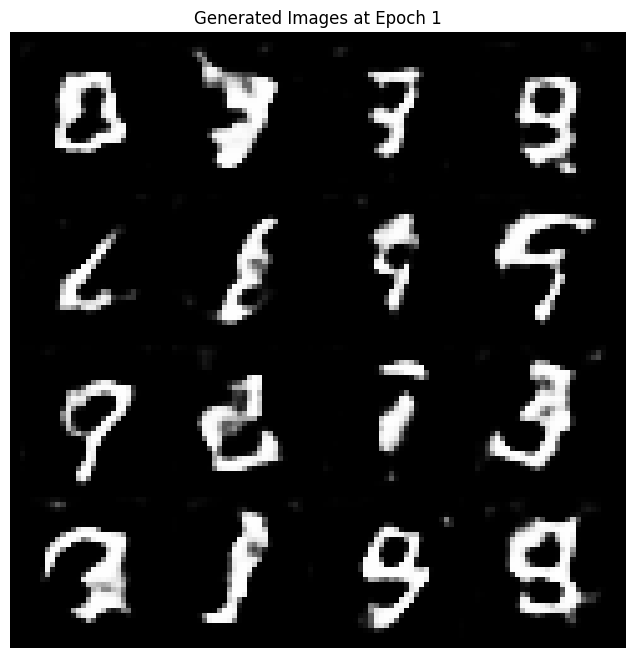

Epoch [2/3] Batch 100/938 Discriminator Loss: 0.2127 Generator Loss: 1.5801
Epoch [2/3] Batch 200/938 Discriminator Loss: 0.2073 Generator Loss: 1.8746
Epoch [2/3] Batch 300/938 Discriminator Loss: 0.2090 Generator Loss: 1.7728
Epoch [2/3] Batch 400/938 Discriminator Loss: 0.2363 Generator Loss: 2.7724
Epoch [2/3] Batch 500/938 Discriminator Loss: 0.2146 Generator Loss: 2.0663
Epoch [2/3] Batch 600/938 Discriminator Loss: 0.1563 Generator Loss: 2.2955
Epoch [2/3] Batch 700/938 Discriminator Loss: 0.1714 Generator Loss: 2.3771
Epoch [2/3] Batch 800/938 Discriminator Loss: 0.1769 Generator Loss: 2.5013
Epoch [2/3] Batch 900/938 Discriminator Loss: 0.2115 Generator Loss: 1.9087


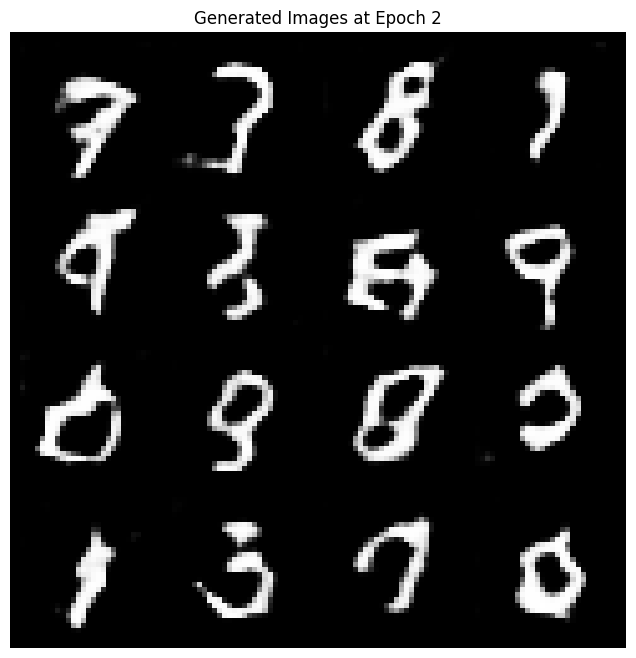

Epoch [3/3] Batch 100/938 Discriminator Loss: 0.2411 Generator Loss: 1.3816
Epoch [3/3] Batch 200/938 Discriminator Loss: 0.1668 Generator Loss: 2.3402
Epoch [3/3] Batch 300/938 Discriminator Loss: 0.7819 Generator Loss: 0.6704
Epoch [3/3] Batch 400/938 Discriminator Loss: 0.1768 Generator Loss: 2.0462
Epoch [3/3] Batch 500/938 Discriminator Loss: 0.1705 Generator Loss: 2.2054
Epoch [3/3] Batch 600/938 Discriminator Loss: 0.2309 Generator Loss: 2.4468
Epoch [3/3] Batch 700/938 Discriminator Loss: 0.2150 Generator Loss: 2.1325
Epoch [3/3] Batch 800/938 Discriminator Loss: 0.3256 Generator Loss: 1.0072
Epoch [3/3] Batch 900/938 Discriminator Loss: 0.1636 Generator Loss: 1.9590


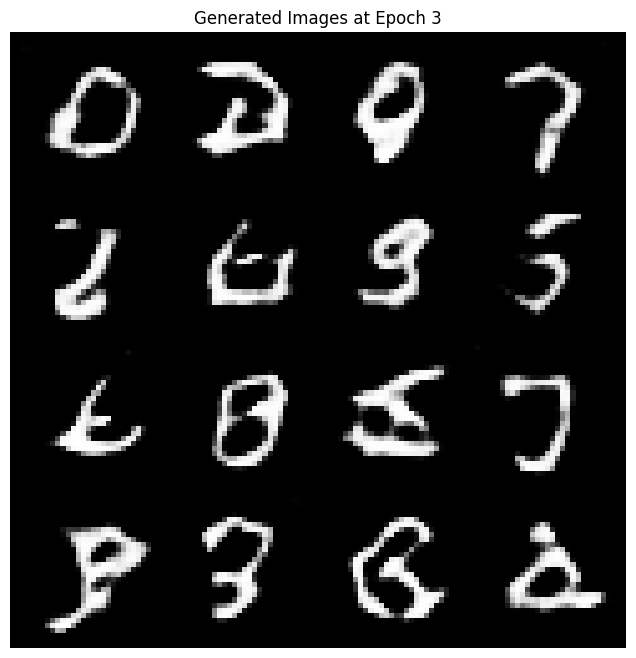

In [ ]:
# Training Loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        # Prepare real and fake labels
        real_images = real_images.to(device)
        valid = torch.ones(real_images.size(0), 1, device=device)
        fake = torch.zeros(real_images.size(0), 1, device=device)

        # Train Discriminator
        optimizer_D.zero_grad()

        z = torch.randn(real_images.size(0), latent_dim, device=device)
        fake_images = generator(z)

        real_loss = adversarial_loss(discriminator(real_images), valid)
        fake_loss = adversarial_loss(discriminator(fake_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        gen_images = generator(z)
        g_loss = adversarial_loss(discriminator(gen_images), valid)

        g_loss.backward()
        optimizer_G.step()

        # Print progress
        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}] Batch {i+1}/{len(dataloader)} "
                f"Discriminator Loss: {d_loss.item():.4f} Generator Loss: {g_loss.item():.4f}"
            )

    # Save and display generated images at each epoch
    with torch.no_grad():
        z = torch.randn(16, latent_dim, device=device)
        generated = generator(z).detach().cpu()
        grid = torchvision.utils.make_grid(generated, nrow=4, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)), cmap="gray")
        plt.title(f"Generated Images at Epoch {epoch + 1}")
        plt.axis("off")
        plt.savefig(f"mnist_generated_epoch_{epoch + 1}.png")
        plt.show()


#Lab Questions
After you run the code, answer the following questions:


Q1. Why do we use two separate loss functions for the Generator and Discriminator?

Q2. What is the purpose of detach() in the Discriminator training step?

Q3. Explain why we use nn.Tanh() in the last layer of the Generator.

Q4. Experiment with changing the architecture of the Generator or Discriminator. What happens to the quality of the generated images?


# **Q1. Why do we use two separate loss functions for the Generator and Discriminator?**

The GAN framework involves two neural networks, the Generator and the Discriminator, competing with each other.
 Their objectives differ:

  •	Discriminator: Tries to distinguish real images from fake ones. Its loss measures its ability to correctly classify real (valid) and fake (fake) images.

	•	Loss: d_loss = (real_loss + fake_loss) / 2.

	•	Generator: Aims to create images that the Discriminator classifies as real. Its loss depends on how well it fools the Discriminator.
  
	•	Loss: g_loss = adversarial_loss(discriminator(gen_images), valid).

Separate loss functions are required because the Generator and Discriminator optimize opposite objectives.

#**Q2. What is the purpose of detach() in the Discriminator training step?**

During the Discriminator training step, the fake images are generated by the Generator:



```
fake_images = generator(z)
fake_loss = adversarial_loss(discriminator(fake_images.detach()), fake)
```

The detach() function prevents gradients from propagating back into the Generator. This ensures that only the Discriminator is updated during this step, keeping the Generator’s parameters unchanged. Without detach(), both networks would inadvertently update during the Discriminator’s step, leading to unstable training.


#**Q3. Explain why we use nn.Tanh() in the last layer of the Generator.**

The nn.Tanh() activation scales the output pixel values of the Generator to the range .
This is particularly useful because:

	1.	Normalization: The pixel values in many datasets (e.g., MNIST) are normalized to . Using Tanh ensures the Generator’s output matches this range.
	2.	Gradient Flow: Tanh helps gradients flow better during training compared to unbounded activations, reducing saturation issues.


#**Q4. Experiment with changing the architecture of the Generator or Discriminator. What happens to the quality of the generated images?**

The quality of generated images depends on the balance between the generator and discriminator during training:


1. Early Epochs: The generator improves gradually as it gets feedback from the discriminator, producing more realistic images.


2. Convergence Point: With proper balance, both the generator and discriminator improve, and the generated images resemble real data.


3. Degradation Risks: If the discriminator becomes too strong, the generator struggles. If the generator becomes too strong, it may cause mode collapse. Overtraining can result in blurry or unrealistic images.



Observations: Early epochs may have low-quality images, which become clearer midway through training, and may either improve or degrade in later epochs based on training stability and hyperparameter tuning.

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 54.5MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.12MB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.2MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.40MB/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Epoch [1/50] Batch 100/938 Discriminator Loss: 0.3351 Generator Loss: 1.3370
Epoch [1/50] Batch 200/938 Discriminator Loss: 0.4008 Generator Loss: 1.4755
Epoch [1/50] Batch 300/938 Discriminator Loss: 0.3134 Generator Loss: 1.7024
Epoch [1/50] Batch 400/938 Discriminator Loss: 0.3332 Generator Loss: 0.9350
Epoch [1/50] Batch 500/938 Discriminator Loss: 0.2599 Generator Loss: 1.2719
Epoch [1/50] Batch 600/938 Discriminator Loss: 0.2490 Generator Loss: 1.8033
Epoch [1/50] Batch 700/938 Discriminator Loss: 0.2569 Generator Loss: 1.5011
Epoch [1/50] Batch 800/938 Discriminator Loss: 0.2048 Generator Loss: 1.8343
Epoch [1/50] Batch 900/938 Discriminator Loss: 0.1924 Generator Loss: 1.7580


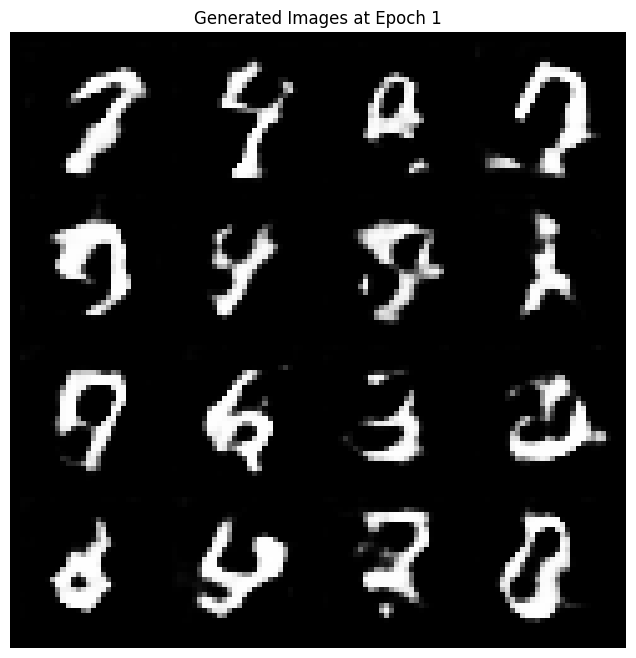

Epoch [2/50] Batch 100/938 Discriminator Loss: 0.2395 Generator Loss: 1.7757
Epoch [2/50] Batch 200/938 Discriminator Loss: 0.3182 Generator Loss: 0.9719
Epoch [2/50] Batch 300/938 Discriminator Loss: 0.3075 Generator Loss: 0.8489
Epoch [2/50] Batch 400/938 Discriminator Loss: 0.2514 Generator Loss: 1.5112
Epoch [2/50] Batch 500/938 Discriminator Loss: 0.2529 Generator Loss: 1.4634
Epoch [2/50] Batch 600/938 Discriminator Loss: 0.2345 Generator Loss: 1.7723
Epoch [2/50] Batch 700/938 Discriminator Loss: 0.2409 Generator Loss: 1.8342
Epoch [2/50] Batch 800/938 Discriminator Loss: 0.2748 Generator Loss: 0.9302
Epoch [2/50] Batch 900/938 Discriminator Loss: 0.2892 Generator Loss: 2.9951


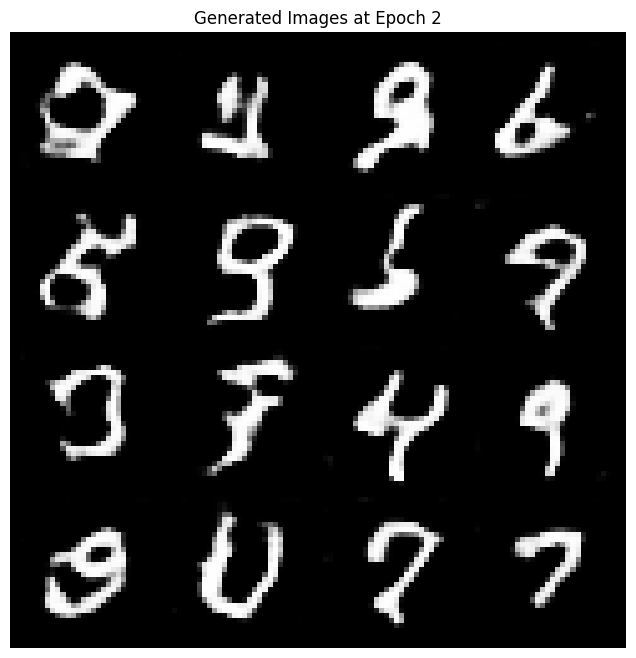

Epoch [3/50] Batch 100/938 Discriminator Loss: 0.2484 Generator Loss: 1.9200
Epoch [3/50] Batch 200/938 Discriminator Loss: 0.2128 Generator Loss: 2.7848
Epoch [3/50] Batch 300/938 Discriminator Loss: 0.1725 Generator Loss: 3.5375
Epoch [3/50] Batch 400/938 Discriminator Loss: 0.2146 Generator Loss: 1.4451
Epoch [3/50] Batch 500/938 Discriminator Loss: 0.3466 Generator Loss: 1.3220
Epoch [3/50] Batch 600/938 Discriminator Loss: 0.2176 Generator Loss: 2.2841
Epoch [3/50] Batch 700/938 Discriminator Loss: 0.1851 Generator Loss: 1.8537
Epoch [3/50] Batch 800/938 Discriminator Loss: 0.3639 Generator Loss: 2.1500
Epoch [3/50] Batch 900/938 Discriminator Loss: 0.2338 Generator Loss: 1.3306


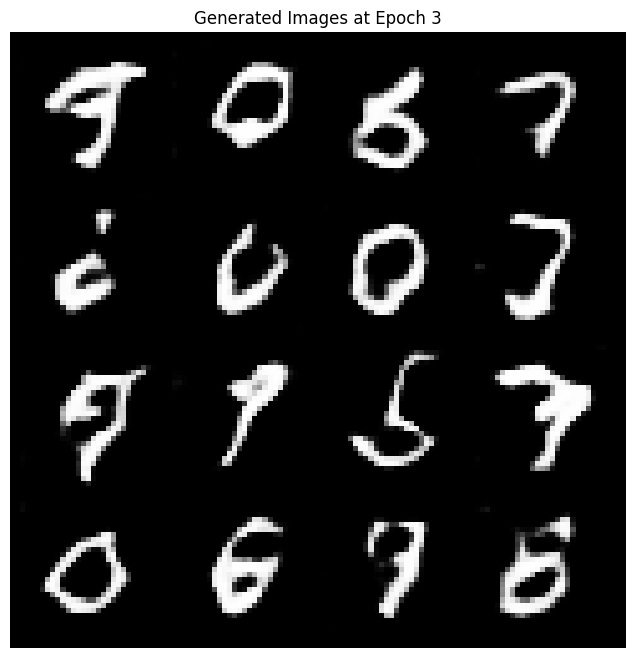

Epoch [4/50] Batch 100/938 Discriminator Loss: 0.1462 Generator Loss: 3.2386
Epoch [4/50] Batch 200/938 Discriminator Loss: 0.2464 Generator Loss: 1.2521
Epoch [4/50] Batch 300/938 Discriminator Loss: 0.2164 Generator Loss: 2.1025
Epoch [4/50] Batch 400/938 Discriminator Loss: 0.2239 Generator Loss: 2.3286
Epoch [4/50] Batch 500/938 Discriminator Loss: 0.2614 Generator Loss: 1.8575
Epoch [4/50] Batch 600/938 Discriminator Loss: 0.2823 Generator Loss: 1.4096
Epoch [4/50] Batch 700/938 Discriminator Loss: 0.1575 Generator Loss: 2.2563
Epoch [4/50] Batch 800/938 Discriminator Loss: 0.2085 Generator Loss: 2.5058
Epoch [4/50] Batch 900/938 Discriminator Loss: 0.2095 Generator Loss: 2.0287


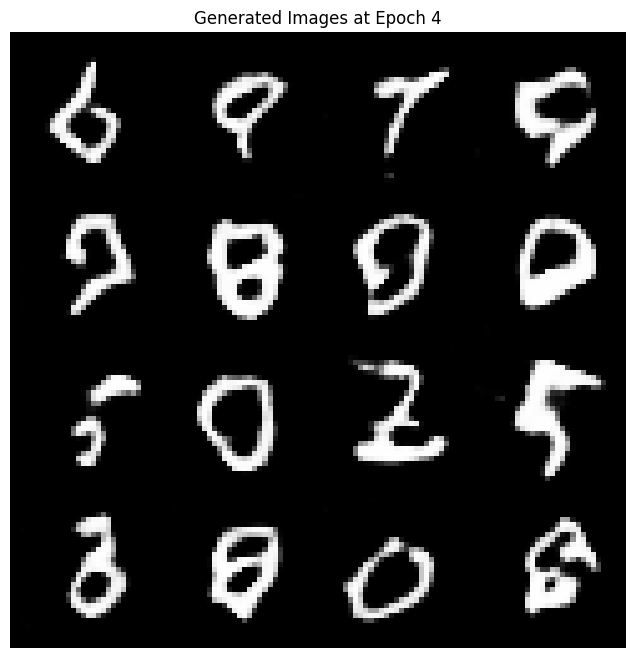

Epoch [5/50] Batch 100/938 Discriminator Loss: 0.2406 Generator Loss: 2.5534
Epoch [5/50] Batch 200/938 Discriminator Loss: 0.1709 Generator Loss: 2.4421
Epoch [5/50] Batch 300/938 Discriminator Loss: 0.1947 Generator Loss: 2.2618
Epoch [5/50] Batch 400/938 Discriminator Loss: 0.2183 Generator Loss: 2.7263
Epoch [5/50] Batch 500/938 Discriminator Loss: 0.1960 Generator Loss: 2.9646
Epoch [5/50] Batch 600/938 Discriminator Loss: 0.1810 Generator Loss: 2.8381
Epoch [5/50] Batch 700/938 Discriminator Loss: 0.1977 Generator Loss: 1.8431
Epoch [5/50] Batch 800/938 Discriminator Loss: 0.1974 Generator Loss: 2.0542
Epoch [5/50] Batch 900/938 Discriminator Loss: 0.1298 Generator Loss: 2.5959


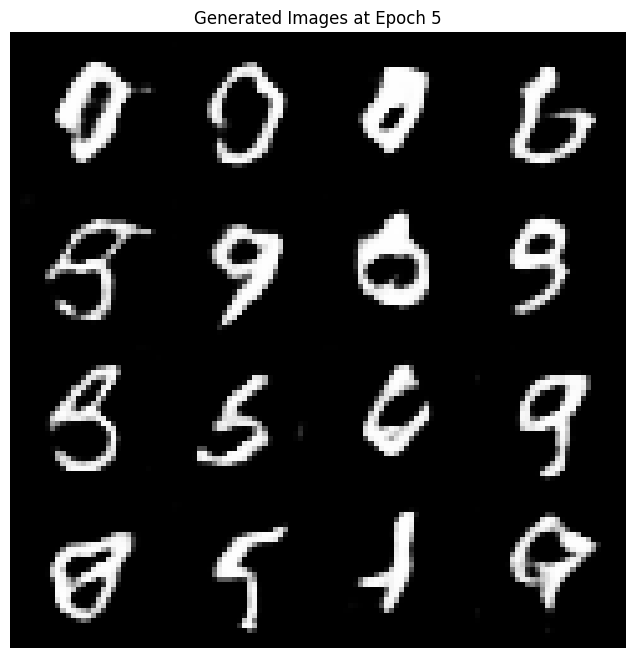

Epoch [6/50] Batch 100/938 Discriminator Loss: 0.2073 Generator Loss: 2.7392
Epoch [6/50] Batch 200/938 Discriminator Loss: 0.2210 Generator Loss: 2.4054
Epoch [6/50] Batch 300/938 Discriminator Loss: 0.2112 Generator Loss: 2.1303
Epoch [6/50] Batch 400/938 Discriminator Loss: 0.3569 Generator Loss: 4.2931
Epoch [6/50] Batch 500/938 Discriminator Loss: 0.1862 Generator Loss: 3.0349
Epoch [6/50] Batch 600/938 Discriminator Loss: 0.2055 Generator Loss: 2.0849
Epoch [6/50] Batch 700/938 Discriminator Loss: 0.2458 Generator Loss: 3.0142
Epoch [6/50] Batch 800/938 Discriminator Loss: 0.1443 Generator Loss: 2.6225
Epoch [6/50] Batch 900/938 Discriminator Loss: 0.1750 Generator Loss: 1.9669


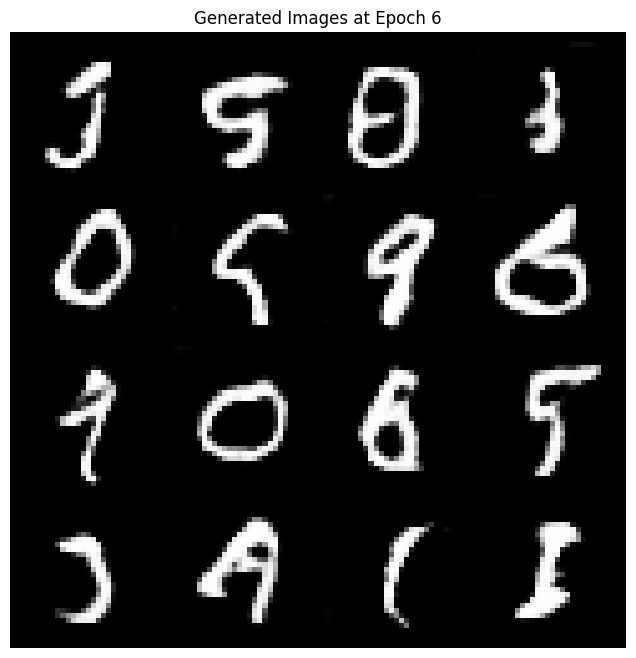

Epoch [7/50] Batch 100/938 Discriminator Loss: 0.2205 Generator Loss: 2.1209
Epoch [7/50] Batch 200/938 Discriminator Loss: 0.1773 Generator Loss: 3.3336
Epoch [7/50] Batch 300/938 Discriminator Loss: 0.1655 Generator Loss: 2.3714
Epoch [7/50] Batch 400/938 Discriminator Loss: 0.3081 Generator Loss: 3.5860
Epoch [7/50] Batch 500/938 Discriminator Loss: 0.1338 Generator Loss: 2.9325
Epoch [7/50] Batch 600/938 Discriminator Loss: 0.1839 Generator Loss: 2.1837
Epoch [7/50] Batch 700/938 Discriminator Loss: 0.4600 Generator Loss: 2.0879
Epoch [7/50] Batch 800/938 Discriminator Loss: 0.1591 Generator Loss: 3.1729
Epoch [7/50] Batch 900/938 Discriminator Loss: 0.1699 Generator Loss: 2.3897


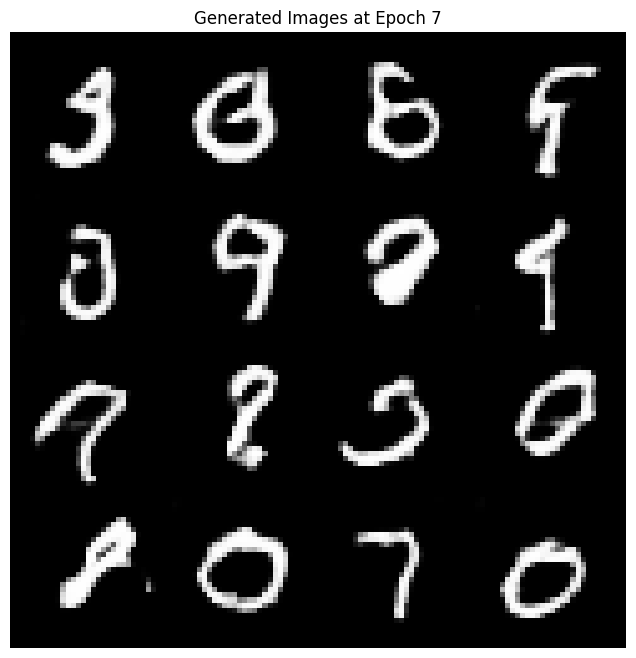

Epoch [8/50] Batch 100/938 Discriminator Loss: 0.2663 Generator Loss: 3.3608
Epoch [8/50] Batch 200/938 Discriminator Loss: 0.1992 Generator Loss: 3.5983
Epoch [8/50] Batch 300/938 Discriminator Loss: 0.2752 Generator Loss: 2.1766
Epoch [8/50] Batch 400/938 Discriminator Loss: 0.1570 Generator Loss: 2.6190
Epoch [8/50] Batch 500/938 Discriminator Loss: 0.2159 Generator Loss: 1.9711
Epoch [8/50] Batch 600/938 Discriminator Loss: 0.1857 Generator Loss: 3.1763
Epoch [8/50] Batch 700/938 Discriminator Loss: 0.1542 Generator Loss: 2.2847
Epoch [8/50] Batch 800/938 Discriminator Loss: 0.3069 Generator Loss: 1.5450
Epoch [8/50] Batch 900/938 Discriminator Loss: 0.1443 Generator Loss: 3.3057


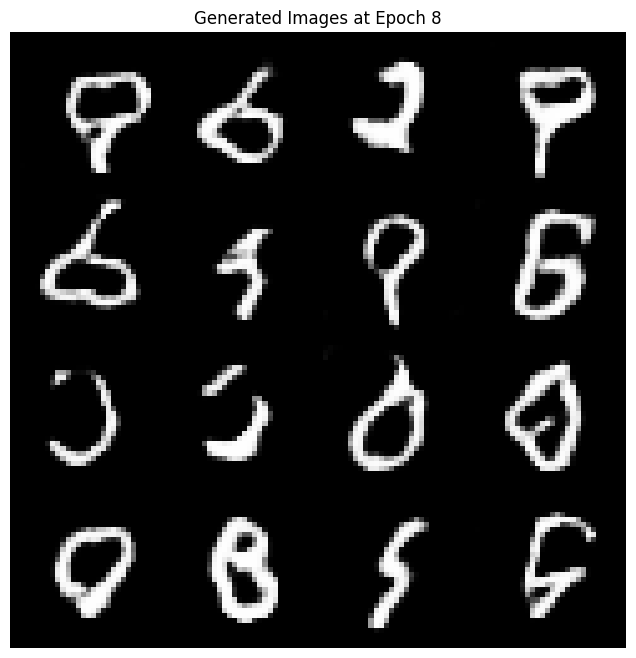

Epoch [9/50] Batch 100/938 Discriminator Loss: 0.1216 Generator Loss: 2.8042
Epoch [9/50] Batch 200/938 Discriminator Loss: 0.1686 Generator Loss: 2.2455
Epoch [9/50] Batch 300/938 Discriminator Loss: 0.2239 Generator Loss: 1.9940
Epoch [9/50] Batch 400/938 Discriminator Loss: 0.2695 Generator Loss: 4.3556
Epoch [9/50] Batch 500/938 Discriminator Loss: 0.2589 Generator Loss: 1.7046
Epoch [9/50] Batch 600/938 Discriminator Loss: 0.2076 Generator Loss: 2.4573
Epoch [9/50] Batch 700/938 Discriminator Loss: 0.1821 Generator Loss: 2.1276
Epoch [9/50] Batch 800/938 Discriminator Loss: 0.2483 Generator Loss: 2.5584
Epoch [9/50] Batch 900/938 Discriminator Loss: 0.3098 Generator Loss: 3.3911


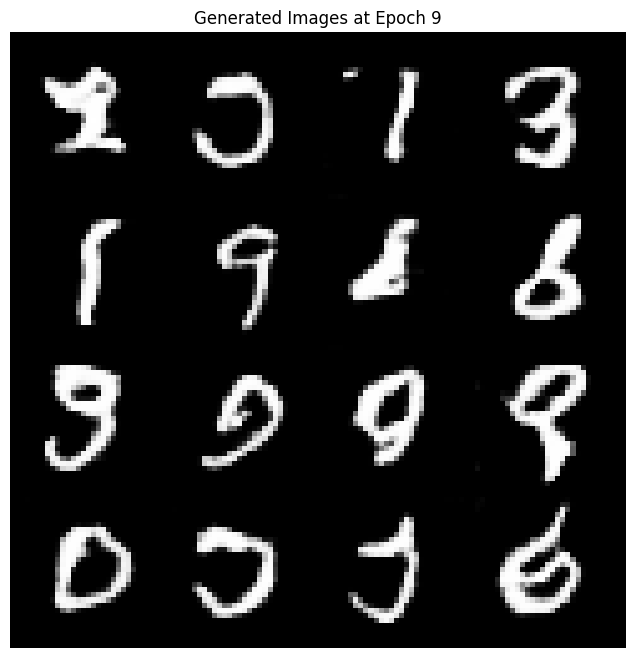

Epoch [10/50] Batch 100/938 Discriminator Loss: 0.2603 Generator Loss: 3.2000
Epoch [10/50] Batch 200/938 Discriminator Loss: 0.1808 Generator Loss: 2.3505
Epoch [10/50] Batch 300/938 Discriminator Loss: 0.1850 Generator Loss: 2.4948
Epoch [10/50] Batch 400/938 Discriminator Loss: 0.1789 Generator Loss: 2.7720
Epoch [10/50] Batch 500/938 Discriminator Loss: 0.1453 Generator Loss: 2.1802
Epoch [10/50] Batch 600/938 Discriminator Loss: 0.2110 Generator Loss: 3.4515
Epoch [10/50] Batch 700/938 Discriminator Loss: 0.1721 Generator Loss: 2.3143
Epoch [10/50] Batch 800/938 Discriminator Loss: 0.1892 Generator Loss: 3.0192
Epoch [10/50] Batch 900/938 Discriminator Loss: 0.1784 Generator Loss: 1.9953


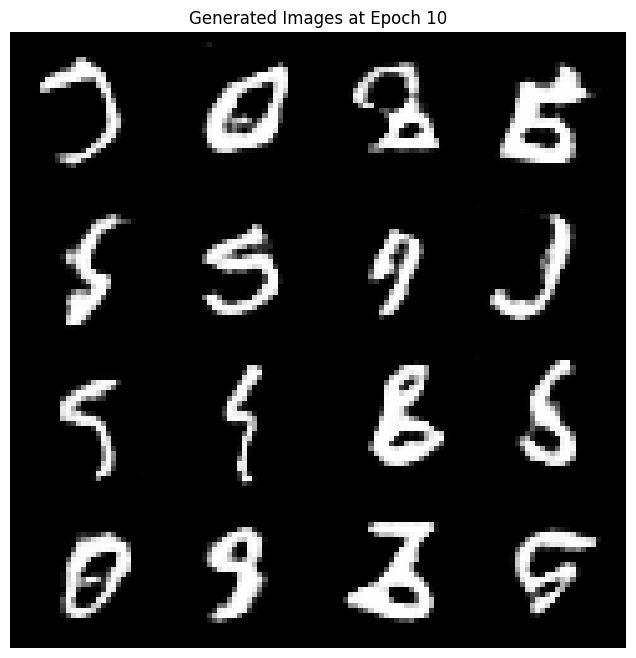

Epoch [11/50] Batch 100/938 Discriminator Loss: 0.1885 Generator Loss: 2.3723
Epoch [11/50] Batch 200/938 Discriminator Loss: 0.2138 Generator Loss: 1.9947
Epoch [11/50] Batch 300/938 Discriminator Loss: 0.1701 Generator Loss: 3.7560
Epoch [11/50] Batch 400/938 Discriminator Loss: 0.2034 Generator Loss: 2.5002
Epoch [11/50] Batch 500/938 Discriminator Loss: 0.1582 Generator Loss: 2.4417
Epoch [11/50] Batch 600/938 Discriminator Loss: 0.1755 Generator Loss: 2.1912
Epoch [11/50] Batch 700/938 Discriminator Loss: 0.1707 Generator Loss: 3.3055
Epoch [11/50] Batch 800/938 Discriminator Loss: 0.2174 Generator Loss: 3.2354
Epoch [11/50] Batch 900/938 Discriminator Loss: 0.1552 Generator Loss: 3.7891


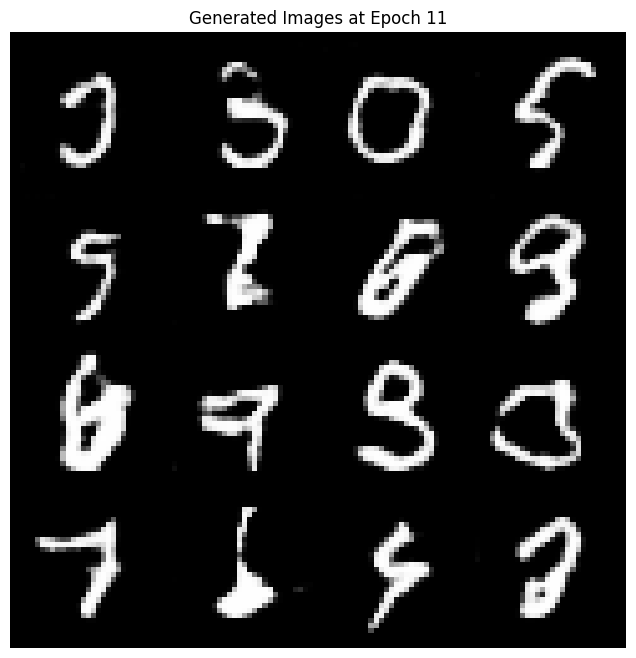

Epoch [12/50] Batch 100/938 Discriminator Loss: 0.1346 Generator Loss: 3.1895
Epoch [12/50] Batch 200/938 Discriminator Loss: 0.1238 Generator Loss: 3.0528
Epoch [12/50] Batch 300/938 Discriminator Loss: 0.1757 Generator Loss: 2.5870
Epoch [12/50] Batch 400/938 Discriminator Loss: 0.1509 Generator Loss: 3.1564
Epoch [12/50] Batch 500/938 Discriminator Loss: 0.1336 Generator Loss: 2.7871
Epoch [12/50] Batch 600/938 Discriminator Loss: 0.1708 Generator Loss: 1.7107
Epoch [12/50] Batch 700/938 Discriminator Loss: 0.2130 Generator Loss: 3.8882
Epoch [12/50] Batch 800/938 Discriminator Loss: 0.2104 Generator Loss: 2.4383
Epoch [12/50] Batch 900/938 Discriminator Loss: 0.2185 Generator Loss: 2.4721


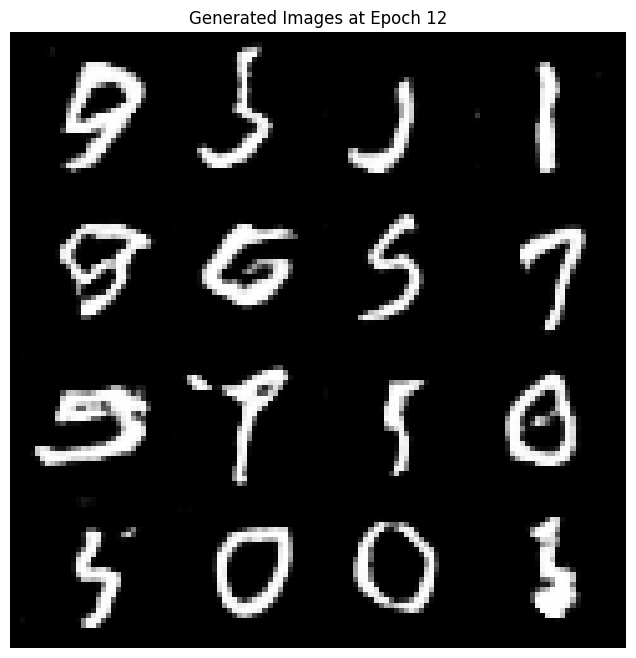

Epoch [13/50] Batch 100/938 Discriminator Loss: 0.1291 Generator Loss: 2.9953
Epoch [13/50] Batch 200/938 Discriminator Loss: 0.1671 Generator Loss: 2.4650
Epoch [13/50] Batch 300/938 Discriminator Loss: 0.2182 Generator Loss: 2.9200
Epoch [13/50] Batch 400/938 Discriminator Loss: 0.1088 Generator Loss: 4.3401
Epoch [13/50] Batch 500/938 Discriminator Loss: 0.1718 Generator Loss: 2.8777
Epoch [13/50] Batch 600/938 Discriminator Loss: 0.1418 Generator Loss: 2.6543
Epoch [13/50] Batch 700/938 Discriminator Loss: 0.1861 Generator Loss: 3.2927
Epoch [13/50] Batch 800/938 Discriminator Loss: 0.3622 Generator Loss: 0.9304
Epoch [13/50] Batch 900/938 Discriminator Loss: 0.1518 Generator Loss: 3.0896


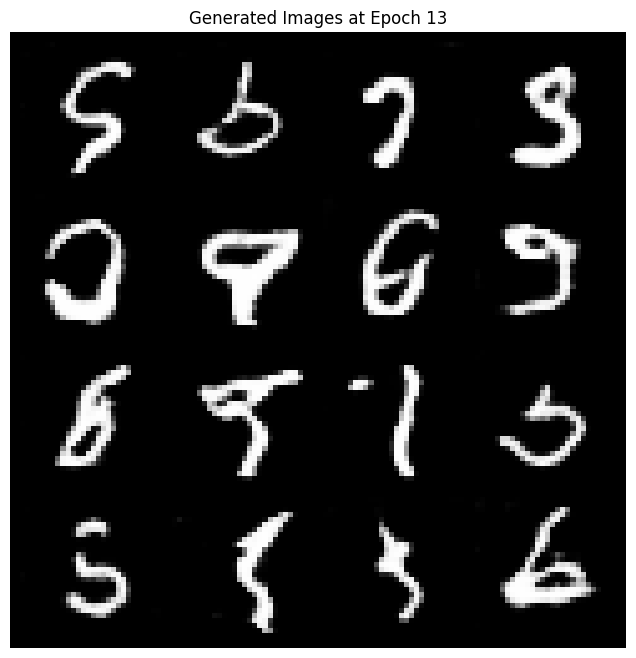

Epoch [14/50] Batch 100/938 Discriminator Loss: 0.1547 Generator Loss: 2.7127
Epoch [14/50] Batch 200/938 Discriminator Loss: 0.1603 Generator Loss: 2.8287
Epoch [14/50] Batch 300/938 Discriminator Loss: 0.1550 Generator Loss: 2.7206
Epoch [14/50] Batch 400/938 Discriminator Loss: 0.1567 Generator Loss: 2.5873
Epoch [14/50] Batch 500/938 Discriminator Loss: 0.3454 Generator Loss: 4.1998
Epoch [14/50] Batch 600/938 Discriminator Loss: 0.2195 Generator Loss: 4.4053
Epoch [14/50] Batch 700/938 Discriminator Loss: 0.1492 Generator Loss: 3.1883
Epoch [14/50] Batch 800/938 Discriminator Loss: 0.1217 Generator Loss: 3.6884
Epoch [14/50] Batch 900/938 Discriminator Loss: 0.1631 Generator Loss: 3.8658


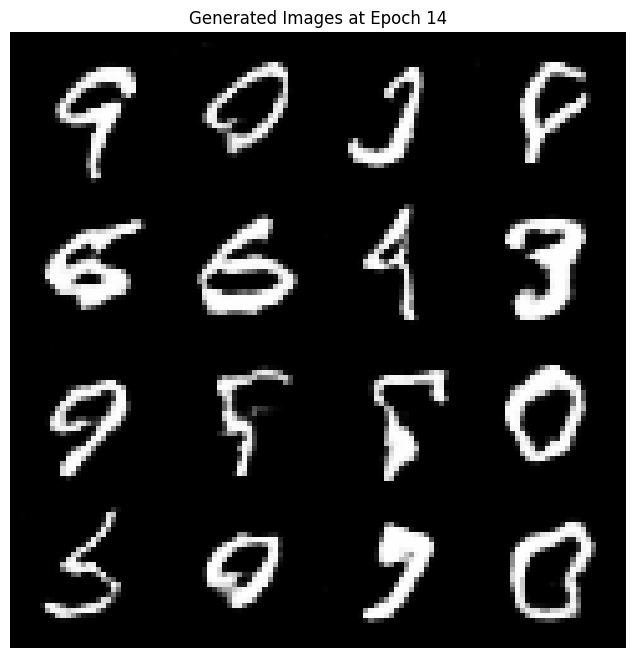

Epoch [15/50] Batch 100/938 Discriminator Loss: 0.1557 Generator Loss: 2.4372
Epoch [15/50] Batch 200/938 Discriminator Loss: 0.1470 Generator Loss: 3.2556
Epoch [15/50] Batch 300/938 Discriminator Loss: 0.3905 Generator Loss: 1.0891
Epoch [15/50] Batch 400/938 Discriminator Loss: 0.1499 Generator Loss: 2.6461
Epoch [15/50] Batch 500/938 Discriminator Loss: 0.1703 Generator Loss: 3.3515
Epoch [15/50] Batch 600/938 Discriminator Loss: 0.1207 Generator Loss: 2.6256
Epoch [15/50] Batch 700/938 Discriminator Loss: 0.2044 Generator Loss: 3.4136
Epoch [15/50] Batch 800/938 Discriminator Loss: 0.1226 Generator Loss: 3.3955
Epoch [15/50] Batch 900/938 Discriminator Loss: 0.1473 Generator Loss: 3.0229


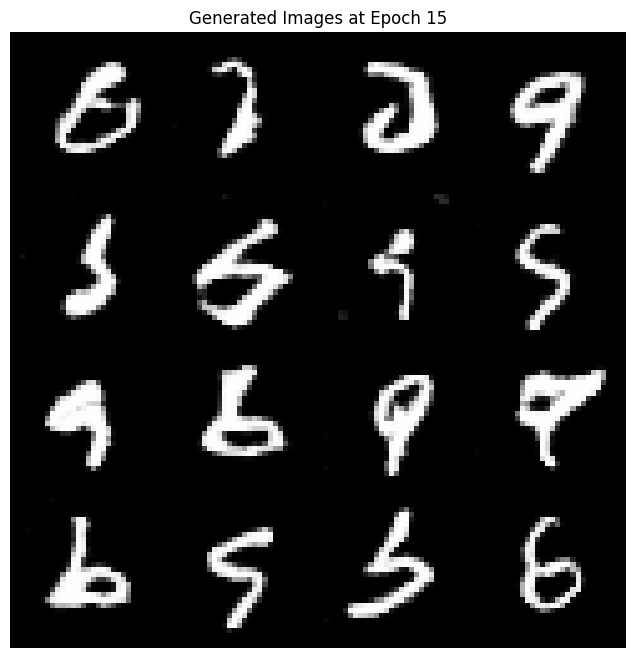

Epoch [16/50] Batch 100/938 Discriminator Loss: 0.1675 Generator Loss: 3.5031
Epoch [16/50] Batch 200/938 Discriminator Loss: 0.1293 Generator Loss: 2.9884
Epoch [16/50] Batch 300/938 Discriminator Loss: 0.1839 Generator Loss: 2.2213
Epoch [16/50] Batch 400/938 Discriminator Loss: 0.2405 Generator Loss: 1.8054
Epoch [16/50] Batch 500/938 Discriminator Loss: 0.1350 Generator Loss: 3.6331
Epoch [16/50] Batch 600/938 Discriminator Loss: 0.2006 Generator Loss: 3.6484
Epoch [16/50] Batch 700/938 Discriminator Loss: 0.1364 Generator Loss: 2.7068
Epoch [16/50] Batch 800/938 Discriminator Loss: 0.2863 Generator Loss: 1.8850
Epoch [16/50] Batch 900/938 Discriminator Loss: 0.2096 Generator Loss: 2.1656


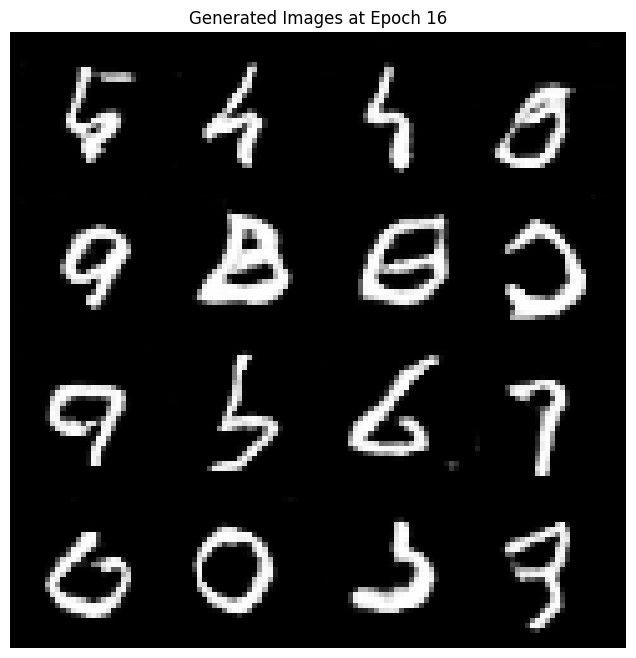

Epoch [17/50] Batch 100/938 Discriminator Loss: 0.1909 Generator Loss: 4.2743
Epoch [17/50] Batch 200/938 Discriminator Loss: 0.1340 Generator Loss: 3.4486
Epoch [17/50] Batch 300/938 Discriminator Loss: 0.1110 Generator Loss: 2.9584
Epoch [17/50] Batch 400/938 Discriminator Loss: 0.1789 Generator Loss: 2.0891
Epoch [17/50] Batch 500/938 Discriminator Loss: 0.1051 Generator Loss: 3.2770
Epoch [17/50] Batch 600/938 Discriminator Loss: 0.1136 Generator Loss: 2.7737
Epoch [17/50] Batch 700/938 Discriminator Loss: 0.1508 Generator Loss: 3.0865
Epoch [17/50] Batch 800/938 Discriminator Loss: 0.4821 Generator Loss: 1.4173
Epoch [17/50] Batch 900/938 Discriminator Loss: 0.2136 Generator Loss: 2.3729


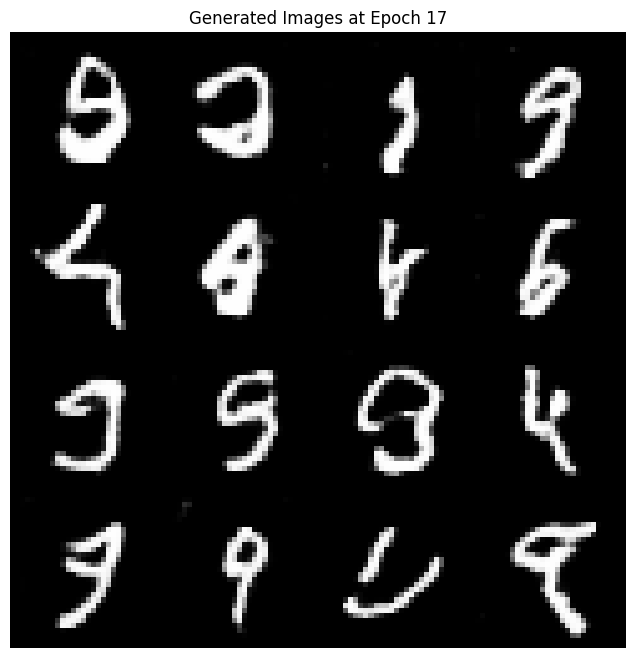

Epoch [18/50] Batch 100/938 Discriminator Loss: 0.1764 Generator Loss: 2.6389
Epoch [18/50] Batch 200/938 Discriminator Loss: 0.1243 Generator Loss: 2.7852
Epoch [18/50] Batch 300/938 Discriminator Loss: 0.1956 Generator Loss: 3.3720
Epoch [18/50] Batch 400/938 Discriminator Loss: 0.0851 Generator Loss: 3.7107
Epoch [18/50] Batch 500/938 Discriminator Loss: 0.2832 Generator Loss: 1.5537
Epoch [18/50] Batch 600/938 Discriminator Loss: 0.1856 Generator Loss: 4.2285
Epoch [18/50] Batch 700/938 Discriminator Loss: 0.1437 Generator Loss: 3.7545
Epoch [18/50] Batch 800/938 Discriminator Loss: 0.1937 Generator Loss: 3.3198
Epoch [18/50] Batch 900/938 Discriminator Loss: 0.1777 Generator Loss: 1.6879


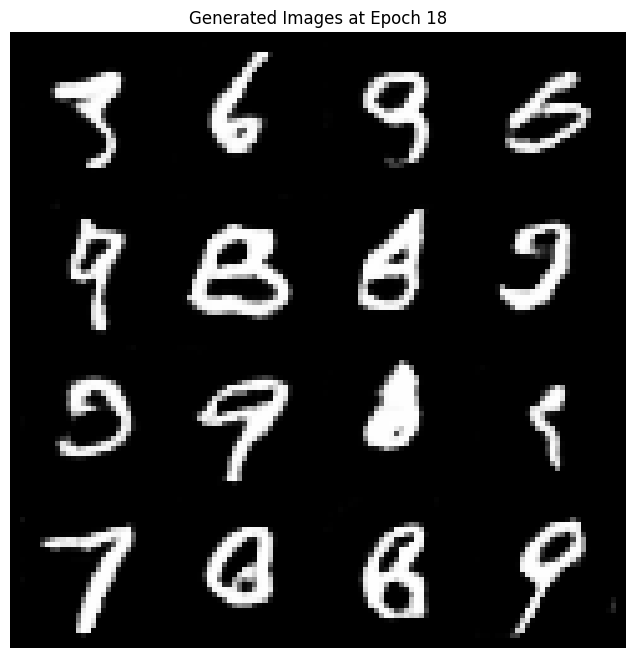

Epoch [19/50] Batch 100/938 Discriminator Loss: 0.1954 Generator Loss: 3.8368
Epoch [19/50] Batch 200/938 Discriminator Loss: 0.1258 Generator Loss: 3.6437
Epoch [19/50] Batch 300/938 Discriminator Loss: 0.4315 Generator Loss: 0.4145
Epoch [19/50] Batch 400/938 Discriminator Loss: 0.2382 Generator Loss: 1.7860
Epoch [19/50] Batch 500/938 Discriminator Loss: 0.2112 Generator Loss: 2.2101
Epoch [19/50] Batch 600/938 Discriminator Loss: 0.1236 Generator Loss: 2.8990
Epoch [19/50] Batch 700/938 Discriminator Loss: 0.1430 Generator Loss: 2.6487
Epoch [19/50] Batch 800/938 Discriminator Loss: 0.4232 Generator Loss: 0.9515
Epoch [19/50] Batch 900/938 Discriminator Loss: 0.1420 Generator Loss: 2.4158


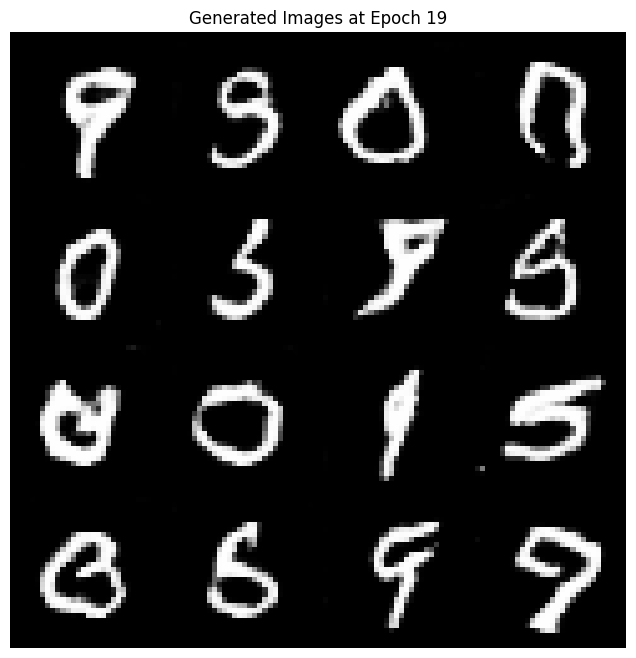

Epoch [20/50] Batch 100/938 Discriminator Loss: 0.3723 Generator Loss: 1.4968
Epoch [20/50] Batch 200/938 Discriminator Loss: 0.1730 Generator Loss: 2.7937
Epoch [20/50] Batch 300/938 Discriminator Loss: 0.1493 Generator Loss: 2.9932
Epoch [20/50] Batch 400/938 Discriminator Loss: 0.2388 Generator Loss: 1.4821
Epoch [20/50] Batch 500/938 Discriminator Loss: 0.1330 Generator Loss: 3.5031
Epoch [20/50] Batch 600/938 Discriminator Loss: 0.1396 Generator Loss: 3.1466
Epoch [20/50] Batch 700/938 Discriminator Loss: 0.1614 Generator Loss: 2.9450
Epoch [20/50] Batch 800/938 Discriminator Loss: 0.1281 Generator Loss: 4.2142
Epoch [20/50] Batch 900/938 Discriminator Loss: 0.1234 Generator Loss: 2.9213


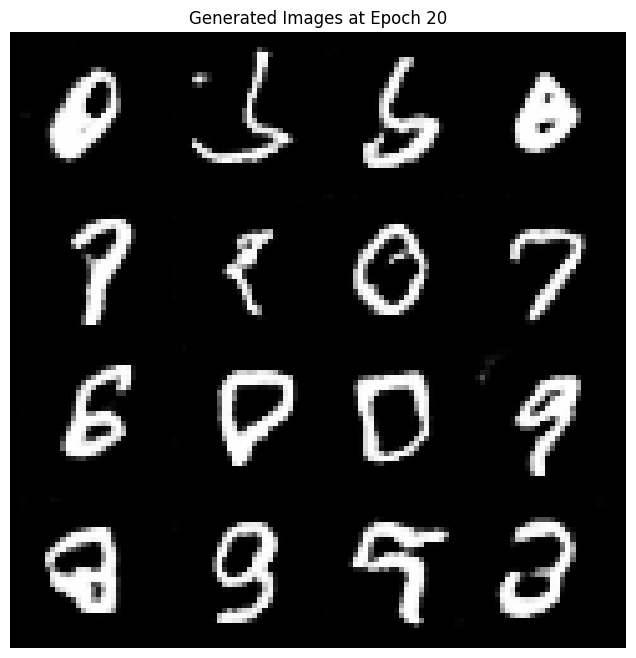

Epoch [21/50] Batch 100/938 Discriminator Loss: 0.2792 Generator Loss: 3.7550
Epoch [21/50] Batch 200/938 Discriminator Loss: 0.2739 Generator Loss: 4.5462
Epoch [21/50] Batch 300/938 Discriminator Loss: 0.1615 Generator Loss: 2.2223
Epoch [21/50] Batch 400/938 Discriminator Loss: 0.1864 Generator Loss: 2.5117
Epoch [21/50] Batch 500/938 Discriminator Loss: 0.2178 Generator Loss: 1.6604
Epoch [21/50] Batch 600/938 Discriminator Loss: 0.1947 Generator Loss: 3.2466
Epoch [21/50] Batch 700/938 Discriminator Loss: 0.2593 Generator Loss: 1.7330
Epoch [21/50] Batch 800/938 Discriminator Loss: 0.2021 Generator Loss: 3.4796
Epoch [21/50] Batch 900/938 Discriminator Loss: 0.1010 Generator Loss: 3.8917


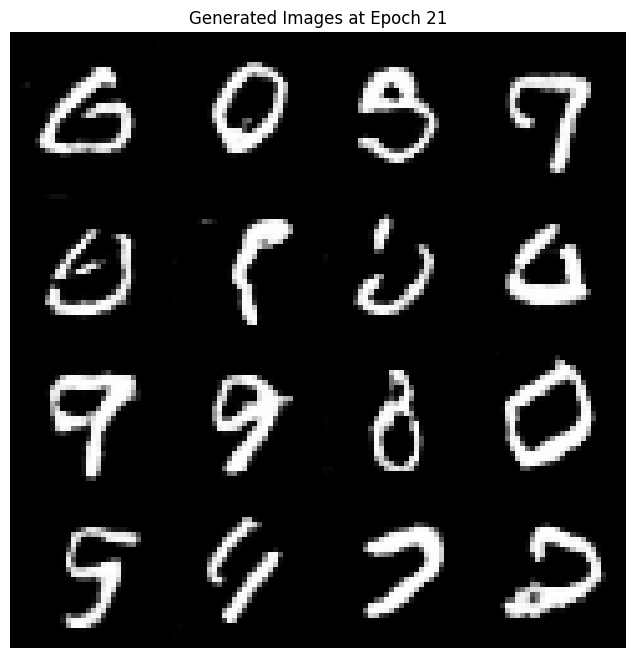

Epoch [22/50] Batch 100/938 Discriminator Loss: 0.1630 Generator Loss: 2.7917
Epoch [22/50] Batch 200/938 Discriminator Loss: 0.1357 Generator Loss: 3.7169
Epoch [22/50] Batch 300/938 Discriminator Loss: 0.1469 Generator Loss: 3.2101
Epoch [22/50] Batch 400/938 Discriminator Loss: 0.1290 Generator Loss: 2.7548
Epoch [22/50] Batch 500/938 Discriminator Loss: 0.2420 Generator Loss: 1.1808
Epoch [22/50] Batch 600/938 Discriminator Loss: 0.1040 Generator Loss: 3.4612
Epoch [22/50] Batch 700/938 Discriminator Loss: 0.1034 Generator Loss: 3.7768
Epoch [22/50] Batch 800/938 Discriminator Loss: 0.1188 Generator Loss: 2.6912
Epoch [22/50] Batch 900/938 Discriminator Loss: 0.1751 Generator Loss: 3.1633


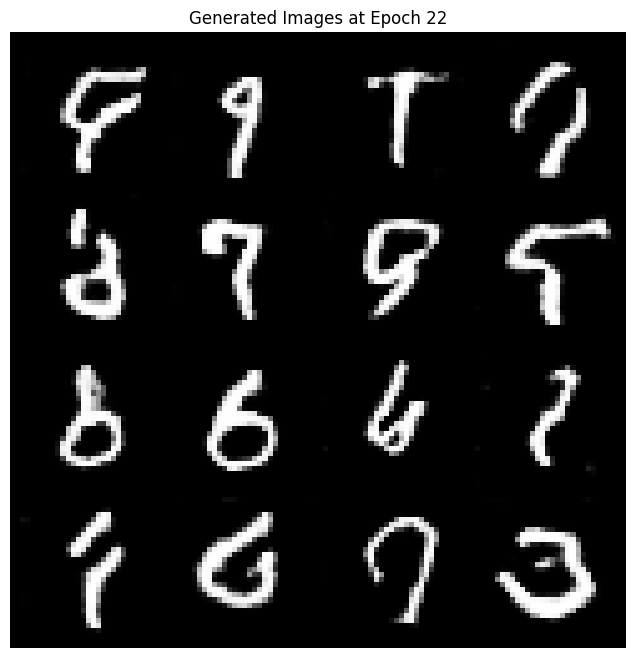

Epoch [23/50] Batch 100/938 Discriminator Loss: 0.1028 Generator Loss: 3.6721
Epoch [23/50] Batch 200/938 Discriminator Loss: 0.1071 Generator Loss: 3.0975
Epoch [23/50] Batch 300/938 Discriminator Loss: 0.1246 Generator Loss: 3.4303
Epoch [23/50] Batch 400/938 Discriminator Loss: 0.1935 Generator Loss: 1.8280
Epoch [23/50] Batch 500/938 Discriminator Loss: 0.1145 Generator Loss: 3.5056
Epoch [23/50] Batch 600/938 Discriminator Loss: 0.1775 Generator Loss: 2.3627
Epoch [23/50] Batch 700/938 Discriminator Loss: 0.1667 Generator Loss: 2.7563
Epoch [23/50] Batch 800/938 Discriminator Loss: 0.2186 Generator Loss: 2.6317
Epoch [23/50] Batch 900/938 Discriminator Loss: 0.1970 Generator Loss: 3.4790


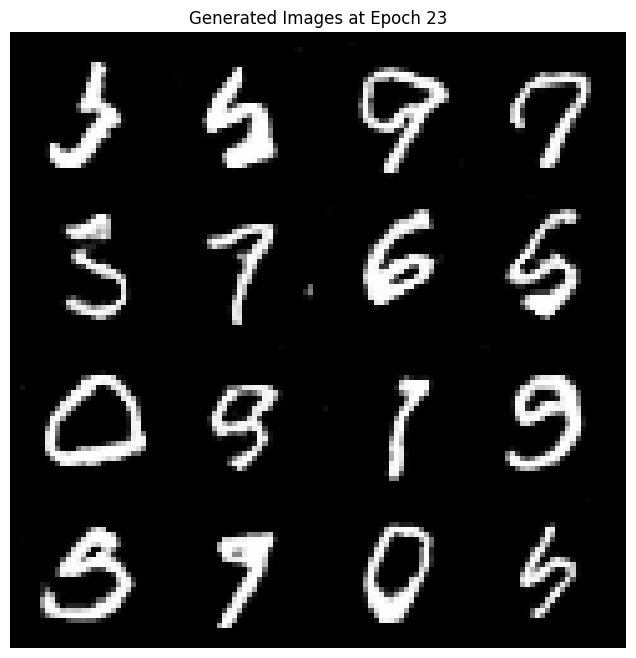

Epoch [24/50] Batch 100/938 Discriminator Loss: 0.1634 Generator Loss: 1.7991
Epoch [24/50] Batch 200/938 Discriminator Loss: 0.1919 Generator Loss: 2.4193
Epoch [24/50] Batch 300/938 Discriminator Loss: 0.1964 Generator Loss: 1.5725
Epoch [24/50] Batch 400/938 Discriminator Loss: 0.0909 Generator Loss: 3.6862
Epoch [24/50] Batch 500/938 Discriminator Loss: 0.1385 Generator Loss: 3.5494
Epoch [24/50] Batch 600/938 Discriminator Loss: 0.2775 Generator Loss: 4.8796
Epoch [24/50] Batch 700/938 Discriminator Loss: 0.2110 Generator Loss: 2.1901
Epoch [24/50] Batch 800/938 Discriminator Loss: 0.1659 Generator Loss: 2.4608
Epoch [24/50] Batch 900/938 Discriminator Loss: 0.1162 Generator Loss: 3.5450


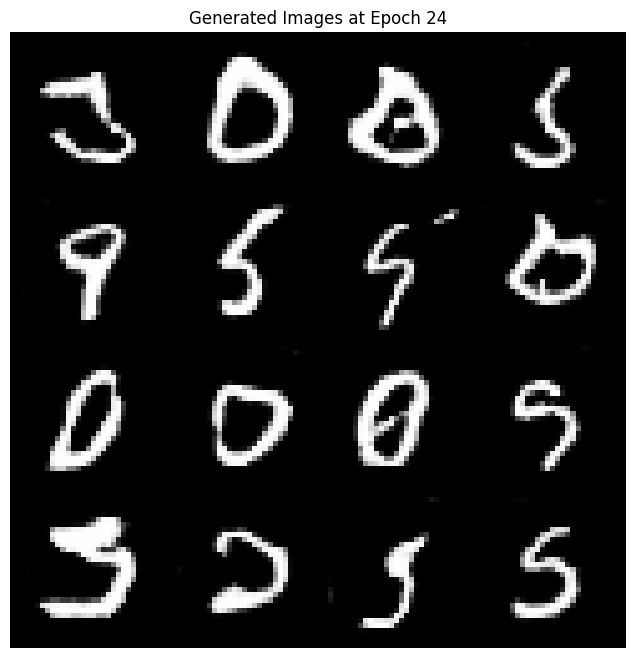

Epoch [25/50] Batch 100/938 Discriminator Loss: 0.3925 Generator Loss: 1.6051
Epoch [25/50] Batch 200/938 Discriminator Loss: 0.1610 Generator Loss: 2.6482
Epoch [25/50] Batch 300/938 Discriminator Loss: 0.1790 Generator Loss: 4.8326
Epoch [25/50] Batch 400/938 Discriminator Loss: 0.1259 Generator Loss: 3.1875
Epoch [25/50] Batch 500/938 Discriminator Loss: 0.1678 Generator Loss: 1.9666
Epoch [25/50] Batch 600/938 Discriminator Loss: 0.1447 Generator Loss: 2.8142
Epoch [25/50] Batch 700/938 Discriminator Loss: 0.1961 Generator Loss: 2.9072
Epoch [25/50] Batch 800/938 Discriminator Loss: 0.1537 Generator Loss: 3.3509
Epoch [25/50] Batch 900/938 Discriminator Loss: 0.3028 Generator Loss: 1.8316


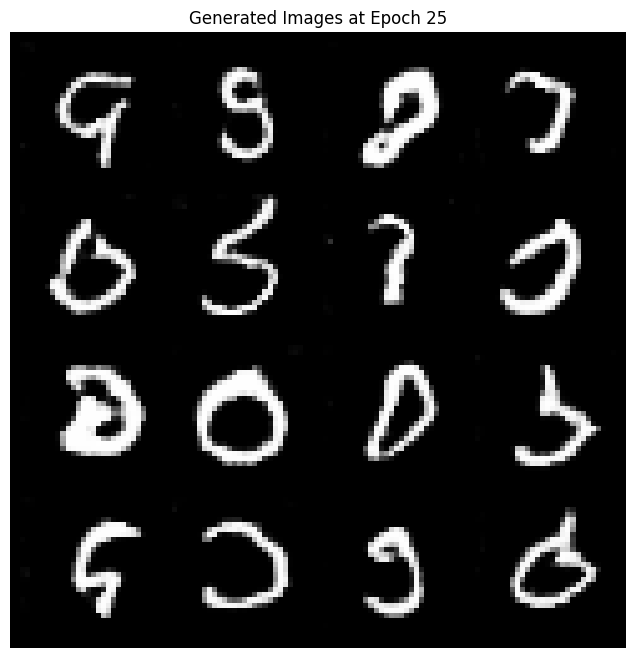

Epoch [26/50] Batch 100/938 Discriminator Loss: 0.4934 Generator Loss: 6.1876
Epoch [26/50] Batch 200/938 Discriminator Loss: 0.1348 Generator Loss: 3.1447
Epoch [26/50] Batch 300/938 Discriminator Loss: 0.1472 Generator Loss: 2.4816
Epoch [26/50] Batch 400/938 Discriminator Loss: 0.1690 Generator Loss: 2.8722
Epoch [26/50] Batch 500/938 Discriminator Loss: 0.1071 Generator Loss: 3.1984
Epoch [26/50] Batch 600/938 Discriminator Loss: 0.1099 Generator Loss: 3.5393
Epoch [26/50] Batch 700/938 Discriminator Loss: 0.1283 Generator Loss: 3.0166
Epoch [26/50] Batch 800/938 Discriminator Loss: 0.1721 Generator Loss: 3.6893
Epoch [26/50] Batch 900/938 Discriminator Loss: 0.0937 Generator Loss: 3.8098


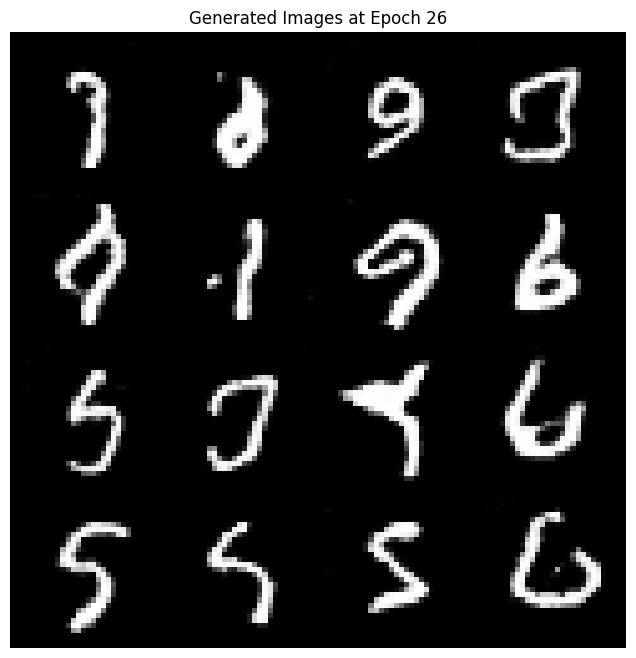

Epoch [27/50] Batch 100/938 Discriminator Loss: 0.2570 Generator Loss: 1.7518
Epoch [27/50] Batch 200/938 Discriminator Loss: 0.1471 Generator Loss: 2.9613
Epoch [27/50] Batch 300/938 Discriminator Loss: 0.1734 Generator Loss: 3.5401
Epoch [27/50] Batch 400/938 Discriminator Loss: 0.1354 Generator Loss: 2.9657
Epoch [27/50] Batch 500/938 Discriminator Loss: 0.2648 Generator Loss: 1.1751
Epoch [27/50] Batch 600/938 Discriminator Loss: 0.1489 Generator Loss: 2.2907
Epoch [27/50] Batch 700/938 Discriminator Loss: 0.2235 Generator Loss: 2.6211
Epoch [27/50] Batch 800/938 Discriminator Loss: 0.1378 Generator Loss: 3.7411
Epoch [27/50] Batch 900/938 Discriminator Loss: 0.1163 Generator Loss: 3.0128


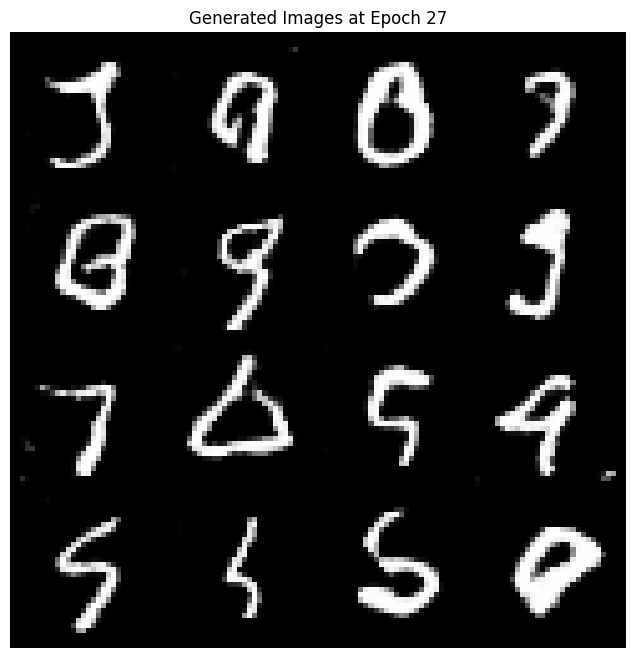

Epoch [28/50] Batch 100/938 Discriminator Loss: 0.1470 Generator Loss: 2.8975
Epoch [28/50] Batch 200/938 Discriminator Loss: 0.1039 Generator Loss: 2.9270
Epoch [28/50] Batch 300/938 Discriminator Loss: 0.1467 Generator Loss: 2.1911
Epoch [28/50] Batch 400/938 Discriminator Loss: 0.2135 Generator Loss: 2.7682
Epoch [28/50] Batch 500/938 Discriminator Loss: 0.1505 Generator Loss: 2.8995
Epoch [28/50] Batch 600/938 Discriminator Loss: 0.1898 Generator Loss: 4.0233
Epoch [28/50] Batch 700/938 Discriminator Loss: 0.1579 Generator Loss: 3.0594
Epoch [28/50] Batch 800/938 Discriminator Loss: 0.1467 Generator Loss: 4.0450
Epoch [28/50] Batch 900/938 Discriminator Loss: 0.1763 Generator Loss: 2.8944


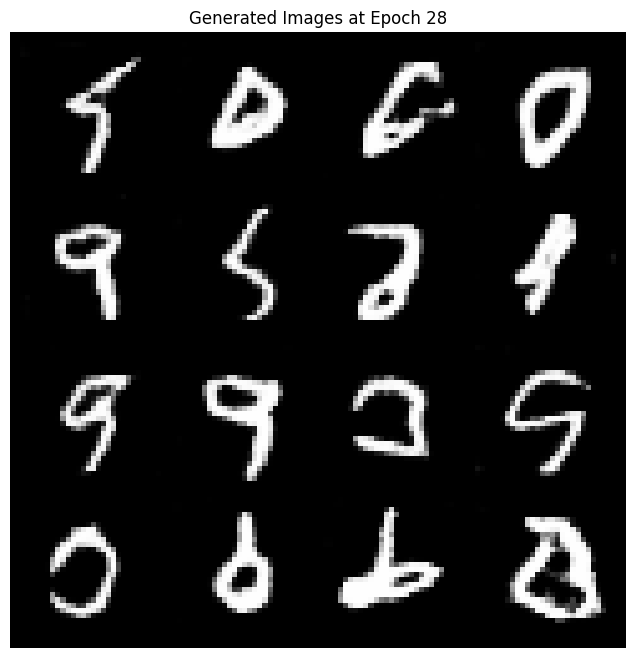

Epoch [29/50] Batch 100/938 Discriminator Loss: 0.2188 Generator Loss: 2.1877
Epoch [29/50] Batch 200/938 Discriminator Loss: 0.3156 Generator Loss: 3.6946
Epoch [29/50] Batch 300/938 Discriminator Loss: 0.2691 Generator Loss: 1.6690
Epoch [29/50] Batch 400/938 Discriminator Loss: 0.2758 Generator Loss: 2.3364
Epoch [29/50] Batch 500/938 Discriminator Loss: 0.1469 Generator Loss: 3.1748
Epoch [29/50] Batch 600/938 Discriminator Loss: 0.1974 Generator Loss: 2.8948
Epoch [29/50] Batch 700/938 Discriminator Loss: 0.1262 Generator Loss: 2.8678
Epoch [29/50] Batch 800/938 Discriminator Loss: 0.2840 Generator Loss: 1.3067
Epoch [29/50] Batch 900/938 Discriminator Loss: 0.1214 Generator Loss: 3.1483


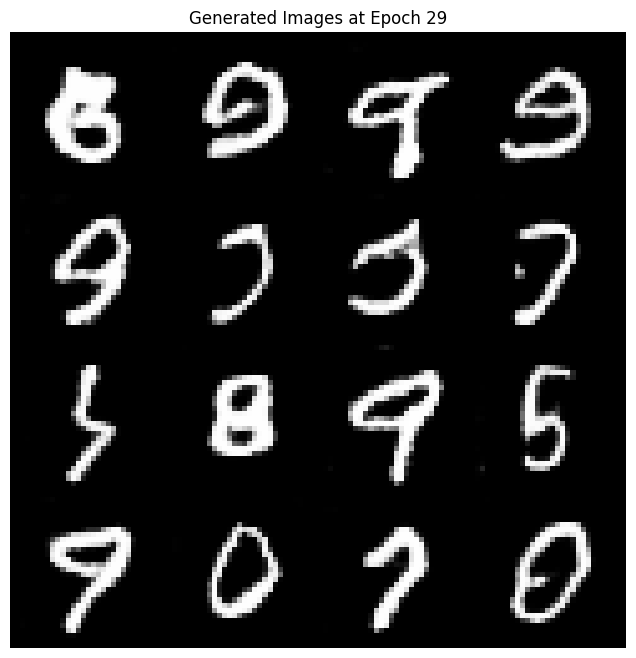

Epoch [30/50] Batch 100/938 Discriminator Loss: 0.1811 Generator Loss: 3.8800
Epoch [30/50] Batch 200/938 Discriminator Loss: 0.1824 Generator Loss: 3.9802
Epoch [30/50] Batch 300/938 Discriminator Loss: 0.1323 Generator Loss: 3.6982
Epoch [30/50] Batch 400/938 Discriminator Loss: 0.1413 Generator Loss: 2.7276
Epoch [30/50] Batch 500/938 Discriminator Loss: 0.1791 Generator Loss: 1.9785
Epoch [30/50] Batch 600/938 Discriminator Loss: 0.1477 Generator Loss: 2.6854
Epoch [30/50] Batch 700/938 Discriminator Loss: 0.1340 Generator Loss: 3.2917
Epoch [30/50] Batch 800/938 Discriminator Loss: 0.2157 Generator Loss: 2.9027
Epoch [30/50] Batch 900/938 Discriminator Loss: 0.1432 Generator Loss: 3.9044


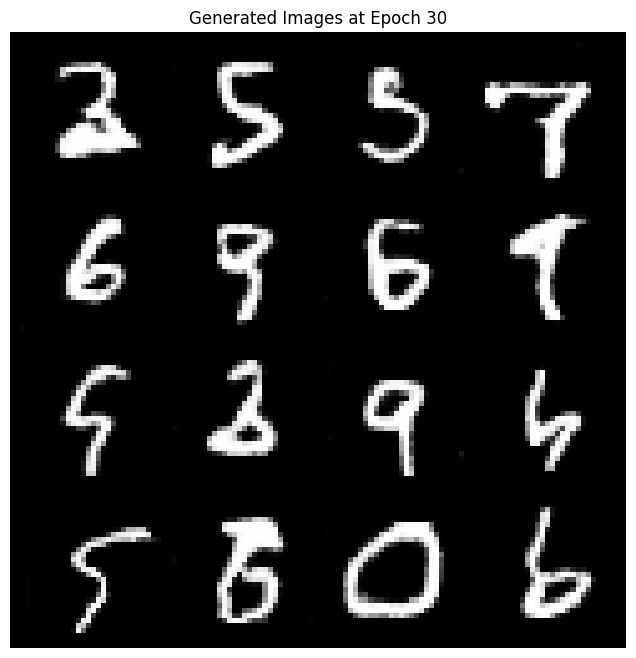

Epoch [31/50] Batch 100/938 Discriminator Loss: 0.2529 Generator Loss: 4.3320
Epoch [31/50] Batch 200/938 Discriminator Loss: 0.1471 Generator Loss: 3.8536
Epoch [31/50] Batch 300/938 Discriminator Loss: 0.0851 Generator Loss: 3.0480
Epoch [31/50] Batch 400/938 Discriminator Loss: 0.2050 Generator Loss: 4.6990
Epoch [31/50] Batch 500/938 Discriminator Loss: 0.1435 Generator Loss: 3.0817
Epoch [31/50] Batch 600/938 Discriminator Loss: 0.1773 Generator Loss: 2.3742
Epoch [31/50] Batch 700/938 Discriminator Loss: 0.1640 Generator Loss: 2.6211
Epoch [31/50] Batch 800/938 Discriminator Loss: 0.1217 Generator Loss: 3.5925
Epoch [31/50] Batch 900/938 Discriminator Loss: 0.1793 Generator Loss: 2.4934


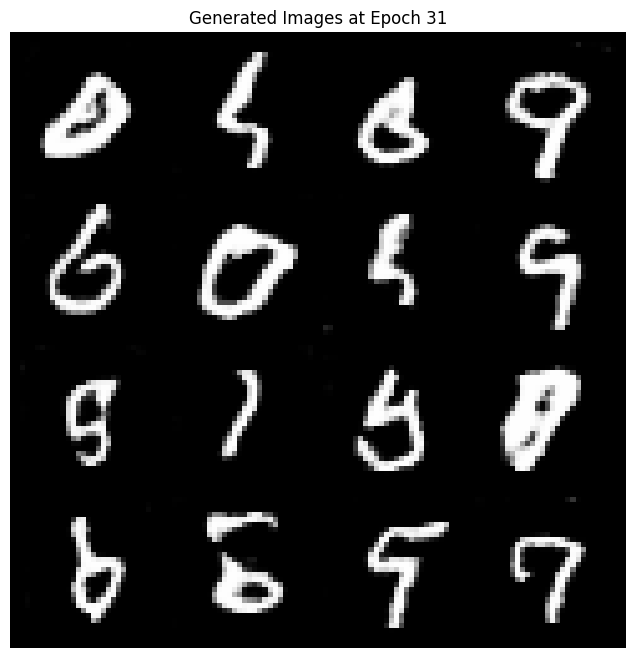

Epoch [32/50] Batch 100/938 Discriminator Loss: 0.1259 Generator Loss: 3.5844
Epoch [32/50] Batch 200/938 Discriminator Loss: 0.2968 Generator Loss: 1.7392
Epoch [32/50] Batch 300/938 Discriminator Loss: 0.1379 Generator Loss: 3.4355
Epoch [32/50] Batch 400/938 Discriminator Loss: 0.1459 Generator Loss: 3.5555
Epoch [32/50] Batch 500/938 Discriminator Loss: 0.1028 Generator Loss: 3.7723
Epoch [32/50] Batch 600/938 Discriminator Loss: 0.0896 Generator Loss: 3.9339
Epoch [32/50] Batch 700/938 Discriminator Loss: 0.1311 Generator Loss: 3.7292
Epoch [32/50] Batch 800/938 Discriminator Loss: 0.2047 Generator Loss: 3.2300
Epoch [32/50] Batch 900/938 Discriminator Loss: 0.1782 Generator Loss: 3.3995


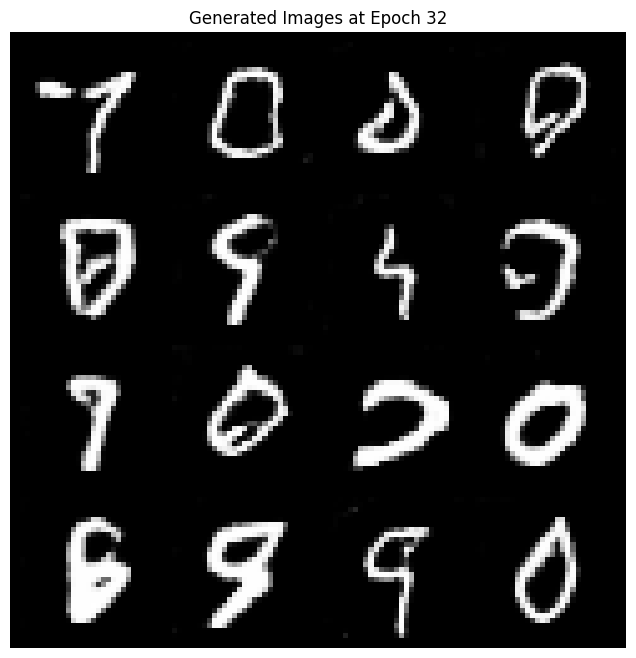

Epoch [33/50] Batch 100/938 Discriminator Loss: 0.4271 Generator Loss: 1.1129
Epoch [33/50] Batch 200/938 Discriminator Loss: 0.1534 Generator Loss: 2.3440
Epoch [33/50] Batch 300/938 Discriminator Loss: 0.1140 Generator Loss: 2.7938
Epoch [33/50] Batch 400/938 Discriminator Loss: 0.2563 Generator Loss: 2.7574
Epoch [33/50] Batch 500/938 Discriminator Loss: 0.3643 Generator Loss: 2.1197
Epoch [33/50] Batch 600/938 Discriminator Loss: 0.1905 Generator Loss: 3.7953
Epoch [33/50] Batch 700/938 Discriminator Loss: 0.1360 Generator Loss: 3.6530
Epoch [33/50] Batch 800/938 Discriminator Loss: 0.1916 Generator Loss: 2.6914
Epoch [33/50] Batch 900/938 Discriminator Loss: 0.1374 Generator Loss: 3.3165


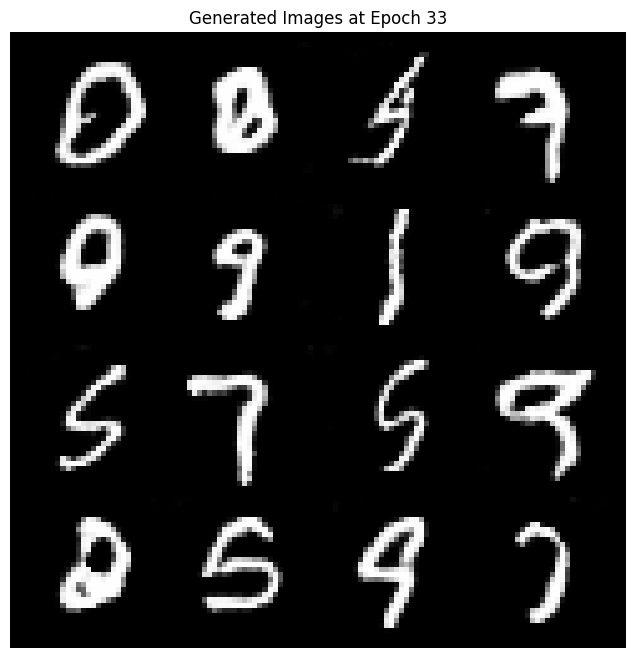

Epoch [34/50] Batch 100/938 Discriminator Loss: 0.1087 Generator Loss: 3.6733
Epoch [34/50] Batch 200/938 Discriminator Loss: 0.1207 Generator Loss: 3.0196
Epoch [34/50] Batch 300/938 Discriminator Loss: 0.3822 Generator Loss: 0.8975
Epoch [34/50] Batch 400/938 Discriminator Loss: 0.2928 Generator Loss: 4.6503
Epoch [34/50] Batch 500/938 Discriminator Loss: 0.2121 Generator Loss: 3.7514
Epoch [34/50] Batch 600/938 Discriminator Loss: 0.1298 Generator Loss: 2.7440
Epoch [34/50] Batch 700/938 Discriminator Loss: 0.1871 Generator Loss: 2.6410
Epoch [34/50] Batch 800/938 Discriminator Loss: 0.1423 Generator Loss: 4.1153
Epoch [34/50] Batch 900/938 Discriminator Loss: 0.2167 Generator Loss: 1.6799


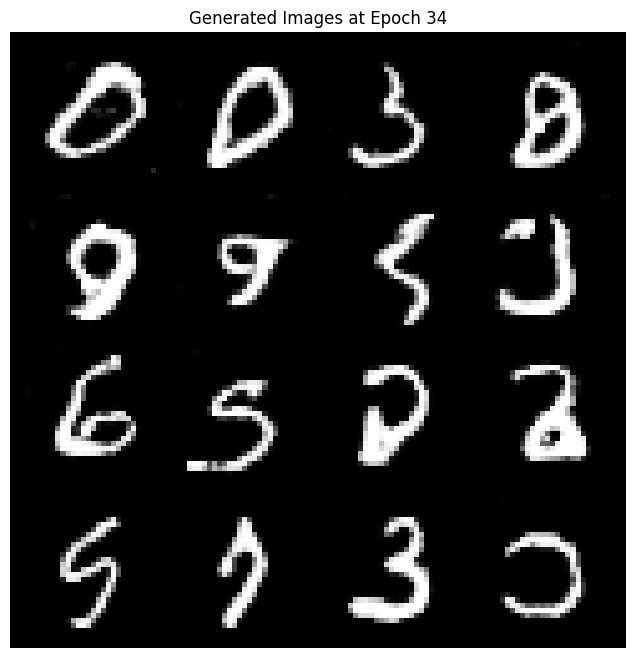

Epoch [35/50] Batch 100/938 Discriminator Loss: 0.2517 Generator Loss: 2.6145
Epoch [35/50] Batch 200/938 Discriminator Loss: 0.1578 Generator Loss: 2.7151
Epoch [35/50] Batch 300/938 Discriminator Loss: 0.1726 Generator Loss: 3.3848
Epoch [35/50] Batch 400/938 Discriminator Loss: 0.2129 Generator Loss: 1.7099
Epoch [35/50] Batch 500/938 Discriminator Loss: 0.1566 Generator Loss: 2.4095
Epoch [35/50] Batch 600/938 Discriminator Loss: 0.1564 Generator Loss: 2.9298
Epoch [35/50] Batch 700/938 Discriminator Loss: 0.1361 Generator Loss: 3.2258
Epoch [35/50] Batch 800/938 Discriminator Loss: 0.1614 Generator Loss: 2.7583
Epoch [35/50] Batch 900/938 Discriminator Loss: 0.2149 Generator Loss: 4.2368


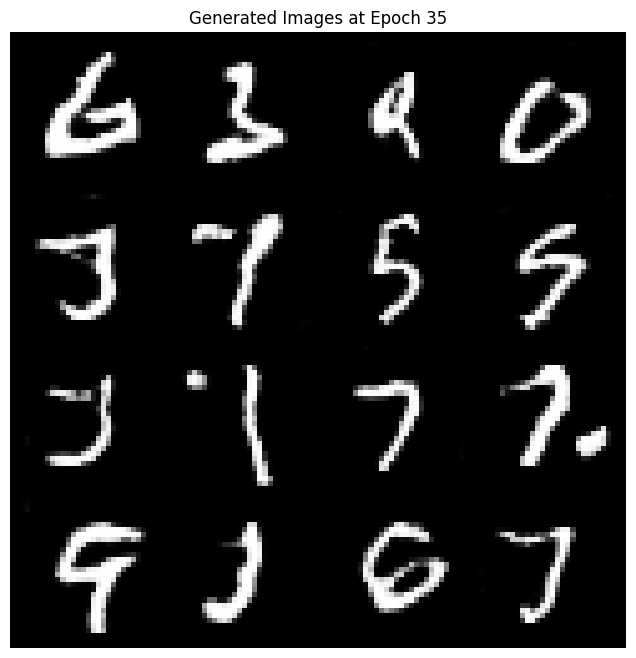

Epoch [36/50] Batch 100/938 Discriminator Loss: 0.1343 Generator Loss: 2.5298
Epoch [36/50] Batch 200/938 Discriminator Loss: 0.2848 Generator Loss: 3.7908
Epoch [36/50] Batch 300/938 Discriminator Loss: 0.0992 Generator Loss: 3.6158
Epoch [36/50] Batch 400/938 Discriminator Loss: 0.1672 Generator Loss: 3.3789
Epoch [36/50] Batch 500/938 Discriminator Loss: 0.1572 Generator Loss: 2.4428
Epoch [36/50] Batch 600/938 Discriminator Loss: 0.2310 Generator Loss: 3.3811
Epoch [36/50] Batch 700/938 Discriminator Loss: 0.1299 Generator Loss: 3.3257
Epoch [36/50] Batch 800/938 Discriminator Loss: 0.1702 Generator Loss: 2.9158
Epoch [36/50] Batch 900/938 Discriminator Loss: 0.1905 Generator Loss: 3.2462


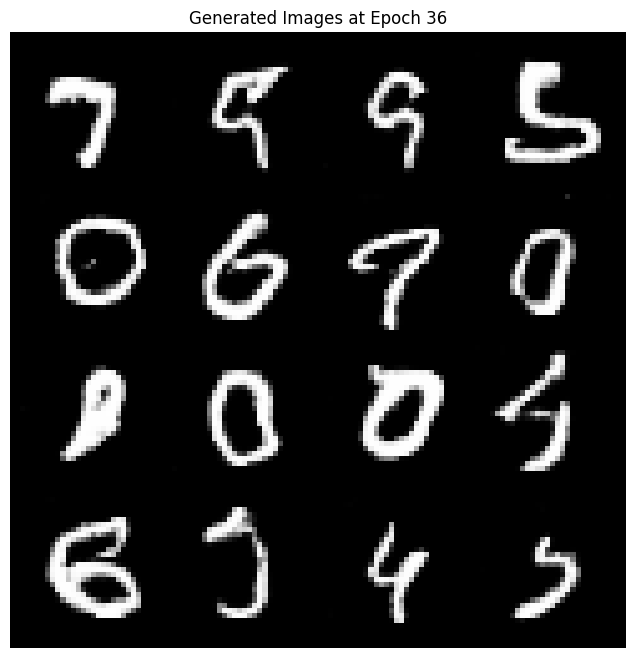

Epoch [37/50] Batch 100/938 Discriminator Loss: 0.2351 Generator Loss: 4.2718
Epoch [37/50] Batch 200/938 Discriminator Loss: 0.2290 Generator Loss: 3.7716
Epoch [37/50] Batch 300/938 Discriminator Loss: 0.1141 Generator Loss: 2.9265
Epoch [37/50] Batch 400/938 Discriminator Loss: 0.1844 Generator Loss: 2.7684
Epoch [37/50] Batch 500/938 Discriminator Loss: 0.1864 Generator Loss: 2.4986
Epoch [37/50] Batch 600/938 Discriminator Loss: 0.3391 Generator Loss: 1.4433
Epoch [37/50] Batch 700/938 Discriminator Loss: 0.1403 Generator Loss: 3.9864
Epoch [37/50] Batch 800/938 Discriminator Loss: 0.1308 Generator Loss: 3.6460
Epoch [37/50] Batch 900/938 Discriminator Loss: 0.1886 Generator Loss: 2.2658


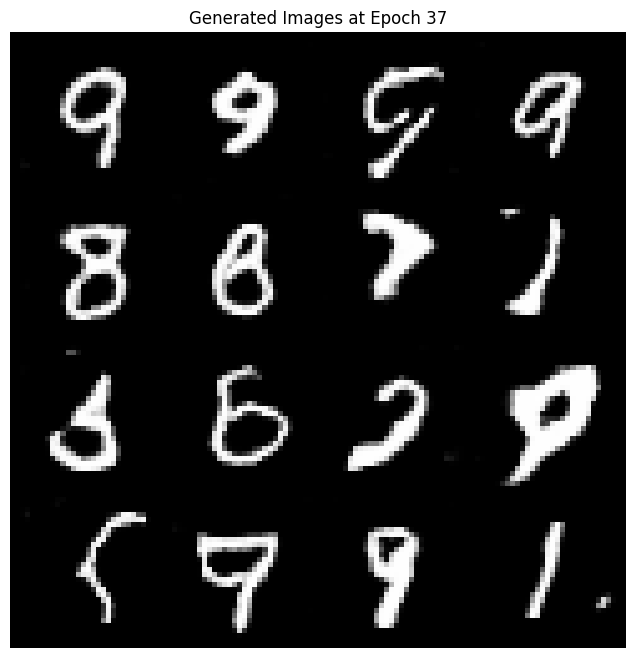

Epoch [38/50] Batch 100/938 Discriminator Loss: 0.1268 Generator Loss: 3.5092
Epoch [38/50] Batch 200/938 Discriminator Loss: 0.2427 Generator Loss: 1.8662
Epoch [38/50] Batch 300/938 Discriminator Loss: 0.2049 Generator Loss: 2.6137
Epoch [38/50] Batch 400/938 Discriminator Loss: 0.1727 Generator Loss: 2.3729
Epoch [38/50] Batch 500/938 Discriminator Loss: 0.1429 Generator Loss: 2.5294
Epoch [38/50] Batch 600/938 Discriminator Loss: 0.2001 Generator Loss: 4.1139
Epoch [38/50] Batch 700/938 Discriminator Loss: 0.1664 Generator Loss: 4.3077
Epoch [38/50] Batch 800/938 Discriminator Loss: 0.1625 Generator Loss: 2.3276
Epoch [38/50] Batch 900/938 Discriminator Loss: 0.2881 Generator Loss: 2.1162


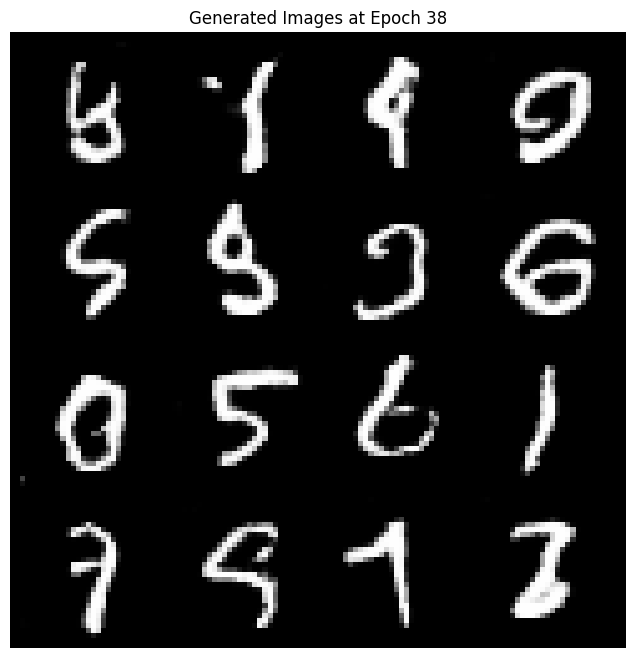

Epoch [39/50] Batch 100/938 Discriminator Loss: 0.0918 Generator Loss: 3.5091
Epoch [39/50] Batch 200/938 Discriminator Loss: 0.1275 Generator Loss: 4.2084
Epoch [39/50] Batch 300/938 Discriminator Loss: 0.2557 Generator Loss: 4.8395
Epoch [39/50] Batch 400/938 Discriminator Loss: 0.1681 Generator Loss: 3.3337
Epoch [39/50] Batch 500/938 Discriminator Loss: 0.2522 Generator Loss: 4.7364
Epoch [39/50] Batch 600/938 Discriminator Loss: 0.1181 Generator Loss: 2.6944
Epoch [39/50] Batch 700/938 Discriminator Loss: 0.3226 Generator Loss: 0.9969
Epoch [39/50] Batch 800/938 Discriminator Loss: 0.1336 Generator Loss: 3.6608
Epoch [39/50] Batch 900/938 Discriminator Loss: 0.6525 Generator Loss: 0.6487


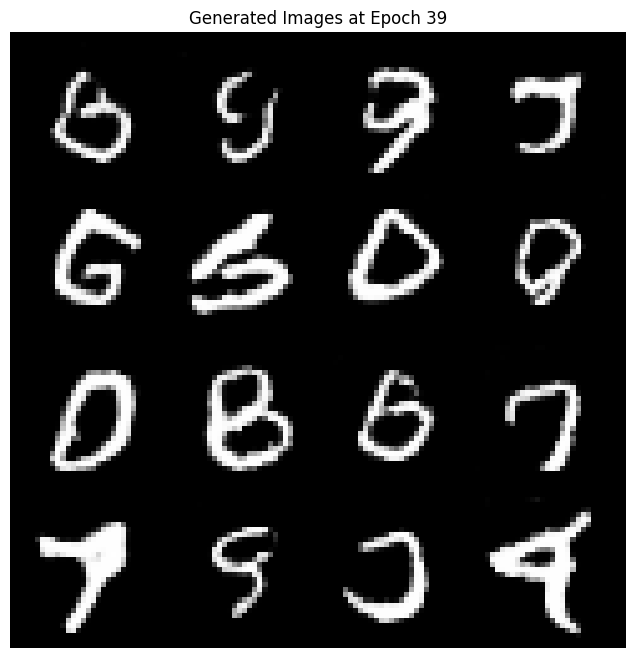

Epoch [40/50] Batch 100/938 Discriminator Loss: 0.1303 Generator Loss: 2.8164
Epoch [40/50] Batch 200/938 Discriminator Loss: 0.1201 Generator Loss: 3.9455
Epoch [40/50] Batch 300/938 Discriminator Loss: 0.1243 Generator Loss: 3.3250
Epoch [40/50] Batch 400/938 Discriminator Loss: 0.1574 Generator Loss: 3.5562
Epoch [40/50] Batch 500/938 Discriminator Loss: 0.1615 Generator Loss: 2.8562
Epoch [40/50] Batch 600/938 Discriminator Loss: 0.1979 Generator Loss: 3.4000
Epoch [40/50] Batch 700/938 Discriminator Loss: 0.1417 Generator Loss: 2.4631
Epoch [40/50] Batch 800/938 Discriminator Loss: 0.1736 Generator Loss: 2.5929
Epoch [40/50] Batch 900/938 Discriminator Loss: 0.1708 Generator Loss: 4.1297


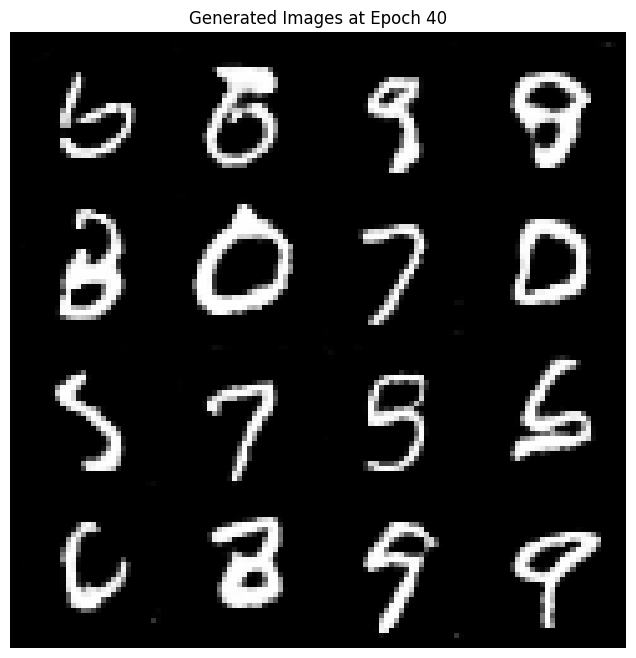

Epoch [41/50] Batch 100/938 Discriminator Loss: 0.1499 Generator Loss: 3.2664
Epoch [41/50] Batch 200/938 Discriminator Loss: 0.1737 Generator Loss: 1.9277
Epoch [41/50] Batch 300/938 Discriminator Loss: 0.2065 Generator Loss: 2.4626
Epoch [41/50] Batch 400/938 Discriminator Loss: 0.2379 Generator Loss: 2.5114
Epoch [41/50] Batch 500/938 Discriminator Loss: 0.1759 Generator Loss: 2.6533
Epoch [41/50] Batch 600/938 Discriminator Loss: 0.1537 Generator Loss: 2.9254
Epoch [41/50] Batch 700/938 Discriminator Loss: 0.3330 Generator Loss: 4.6675
Epoch [41/50] Batch 800/938 Discriminator Loss: 0.1660 Generator Loss: 3.0593
Epoch [41/50] Batch 900/938 Discriminator Loss: 0.1251 Generator Loss: 3.2063


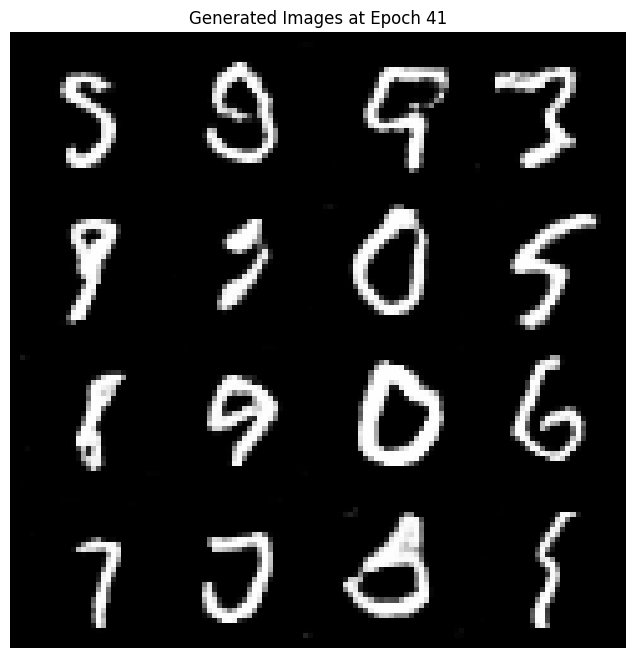

Epoch [42/50] Batch 100/938 Discriminator Loss: 0.1026 Generator Loss: 3.5640
Epoch [42/50] Batch 200/938 Discriminator Loss: 0.2243 Generator Loss: 1.5498
Epoch [42/50] Batch 300/938 Discriminator Loss: 0.1402 Generator Loss: 2.7912
Epoch [42/50] Batch 400/938 Discriminator Loss: 0.1311 Generator Loss: 2.8507
Epoch [42/50] Batch 500/938 Discriminator Loss: 0.2059 Generator Loss: 2.4114
Epoch [42/50] Batch 600/938 Discriminator Loss: 0.1729 Generator Loss: 2.8103
Epoch [42/50] Batch 700/938 Discriminator Loss: 0.2046 Generator Loss: 3.3310
Epoch [42/50] Batch 800/938 Discriminator Loss: 0.1336 Generator Loss: 3.5169
Epoch [42/50] Batch 900/938 Discriminator Loss: 0.1729 Generator Loss: 2.4759


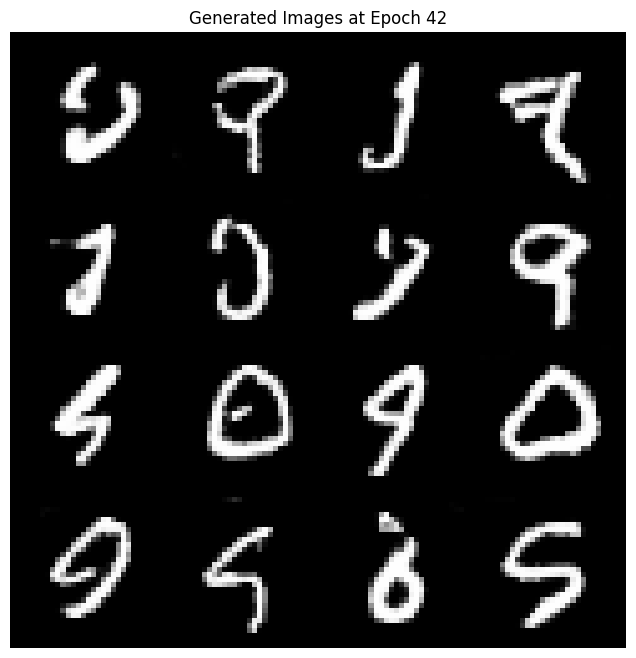

Epoch [43/50] Batch 100/938 Discriminator Loss: 0.2249 Generator Loss: 2.1271
Epoch [43/50] Batch 200/938 Discriminator Loss: 0.1073 Generator Loss: 2.9099
Epoch [43/50] Batch 300/938 Discriminator Loss: 0.1615 Generator Loss: 3.6866
Epoch [43/50] Batch 400/938 Discriminator Loss: 0.1241 Generator Loss: 3.1924
Epoch [43/50] Batch 500/938 Discriminator Loss: 0.1851 Generator Loss: 3.8466
Epoch [43/50] Batch 600/938 Discriminator Loss: 0.2644 Generator Loss: 1.3412
Epoch [43/50] Batch 700/938 Discriminator Loss: 0.1092 Generator Loss: 3.4768
Epoch [43/50] Batch 800/938 Discriminator Loss: 0.2029 Generator Loss: 1.9873
Epoch [43/50] Batch 900/938 Discriminator Loss: 0.3074 Generator Loss: 3.8490


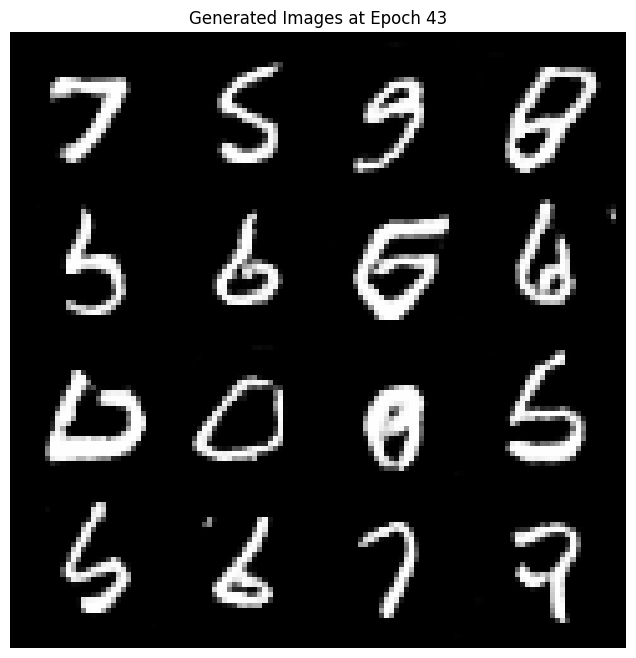

Epoch [44/50] Batch 100/938 Discriminator Loss: 0.2068 Generator Loss: 2.7641
Epoch [44/50] Batch 200/938 Discriminator Loss: 0.1394 Generator Loss: 3.1920
Epoch [44/50] Batch 300/938 Discriminator Loss: 0.1318 Generator Loss: 3.6829
Epoch [44/50] Batch 400/938 Discriminator Loss: 0.1657 Generator Loss: 3.6045
Epoch [44/50] Batch 500/938 Discriminator Loss: 0.1096 Generator Loss: 3.1861
Epoch [44/50] Batch 600/938 Discriminator Loss: 0.1384 Generator Loss: 3.5046
Epoch [44/50] Batch 700/938 Discriminator Loss: 0.1551 Generator Loss: 3.0382
Epoch [44/50] Batch 800/938 Discriminator Loss: 0.1958 Generator Loss: 3.3011
Epoch [44/50] Batch 900/938 Discriminator Loss: 0.1421 Generator Loss: 3.2323


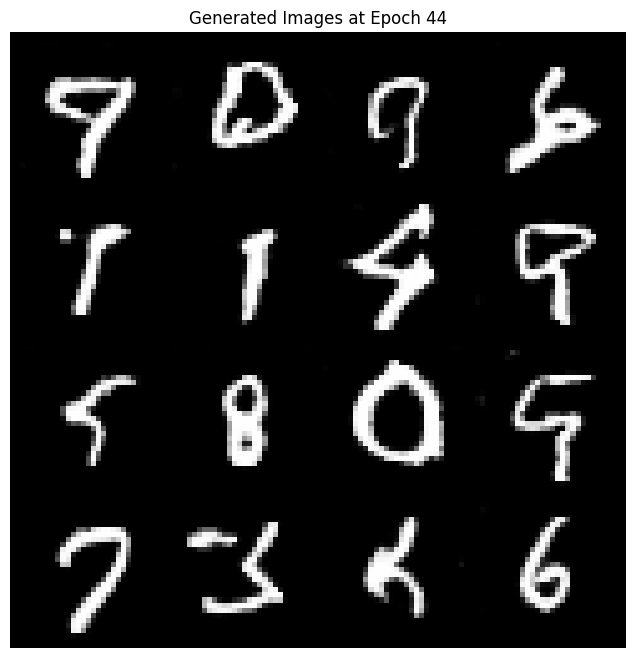

Epoch [45/50] Batch 100/938 Discriminator Loss: 0.1469 Generator Loss: 2.9146
Epoch [45/50] Batch 200/938 Discriminator Loss: 0.1428 Generator Loss: 4.1669
Epoch [45/50] Batch 300/938 Discriminator Loss: 0.1690 Generator Loss: 2.7301
Epoch [45/50] Batch 400/938 Discriminator Loss: 0.1333 Generator Loss: 3.9308
Epoch [45/50] Batch 500/938 Discriminator Loss: 0.1612 Generator Loss: 2.0773
Epoch [45/50] Batch 600/938 Discriminator Loss: 0.1430 Generator Loss: 3.8194
Epoch [45/50] Batch 700/938 Discriminator Loss: 0.1464 Generator Loss: 3.8278
Epoch [45/50] Batch 800/938 Discriminator Loss: 0.2595 Generator Loss: 2.3305
Epoch [45/50] Batch 900/938 Discriminator Loss: 0.1727 Generator Loss: 2.9912


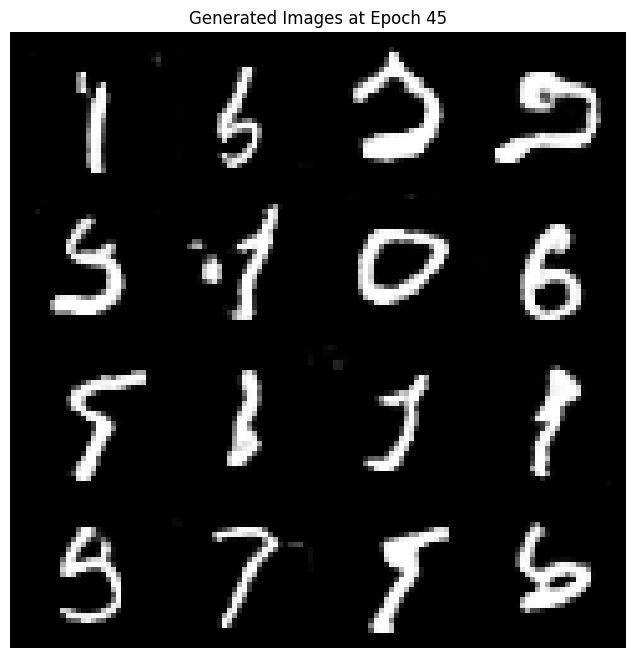

Epoch [46/50] Batch 100/938 Discriminator Loss: 0.1398 Generator Loss: 4.1121
Epoch [46/50] Batch 200/938 Discriminator Loss: 0.1425 Generator Loss: 2.8353
Epoch [46/50] Batch 300/938 Discriminator Loss: 0.1528 Generator Loss: 2.2984
Epoch [46/50] Batch 400/938 Discriminator Loss: 0.2001 Generator Loss: 4.5448
Epoch [46/50] Batch 500/938 Discriminator Loss: 0.1973 Generator Loss: 4.6225
Epoch [46/50] Batch 600/938 Discriminator Loss: 0.1847 Generator Loss: 2.7289
Epoch [46/50] Batch 700/938 Discriminator Loss: 0.1415 Generator Loss: 3.6429
Epoch [46/50] Batch 800/938 Discriminator Loss: 0.1386 Generator Loss: 3.5622
Epoch [46/50] Batch 900/938 Discriminator Loss: 0.1685 Generator Loss: 2.9435


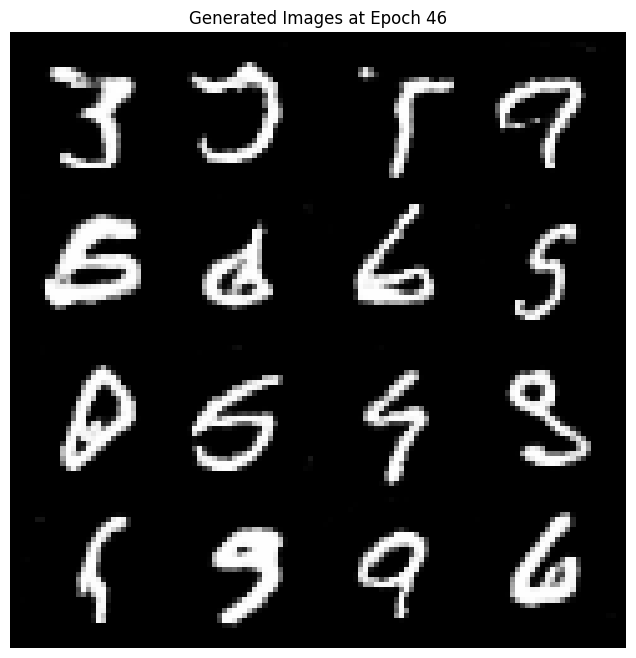

Epoch [47/50] Batch 100/938 Discriminator Loss: 0.1240 Generator Loss: 3.3066
Epoch [47/50] Batch 200/938 Discriminator Loss: 0.1678 Generator Loss: 4.1192
Epoch [47/50] Batch 300/938 Discriminator Loss: 0.3388 Generator Loss: 5.3690
Epoch [47/50] Batch 400/938 Discriminator Loss: 0.2020 Generator Loss: 1.8132
Epoch [47/50] Batch 500/938 Discriminator Loss: 0.1847 Generator Loss: 2.6047
Epoch [47/50] Batch 600/938 Discriminator Loss: 0.4166 Generator Loss: 5.4910
Epoch [47/50] Batch 700/938 Discriminator Loss: 0.1560 Generator Loss: 2.8591
Epoch [47/50] Batch 800/938 Discriminator Loss: 0.1753 Generator Loss: 3.5908
Epoch [47/50] Batch 900/938 Discriminator Loss: 0.2474 Generator Loss: 4.2707


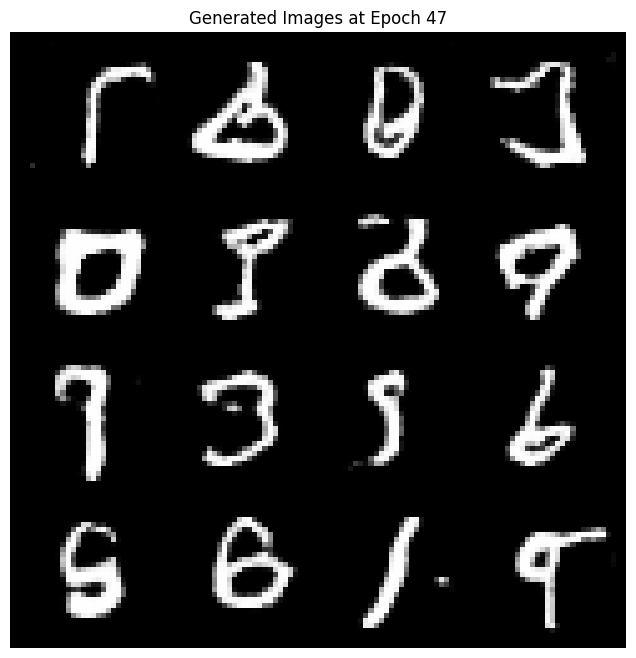

Epoch [48/50] Batch 100/938 Discriminator Loss: 0.1080 Generator Loss: 2.8040
Epoch [48/50] Batch 200/938 Discriminator Loss: 0.1143 Generator Loss: 3.4504
Epoch [48/50] Batch 300/938 Discriminator Loss: 0.0986 Generator Loss: 3.4842
Epoch [48/50] Batch 400/938 Discriminator Loss: 0.1519 Generator Loss: 2.5366
Epoch [48/50] Batch 500/938 Discriminator Loss: 0.1683 Generator Loss: 3.1633
Epoch [48/50] Batch 600/938 Discriminator Loss: 0.1392 Generator Loss: 3.7317
Epoch [48/50] Batch 700/938 Discriminator Loss: 0.1705 Generator Loss: 4.9918
Epoch [48/50] Batch 800/938 Discriminator Loss: 0.2187 Generator Loss: 2.3793
Epoch [48/50] Batch 900/938 Discriminator Loss: 0.1846 Generator Loss: 2.7617


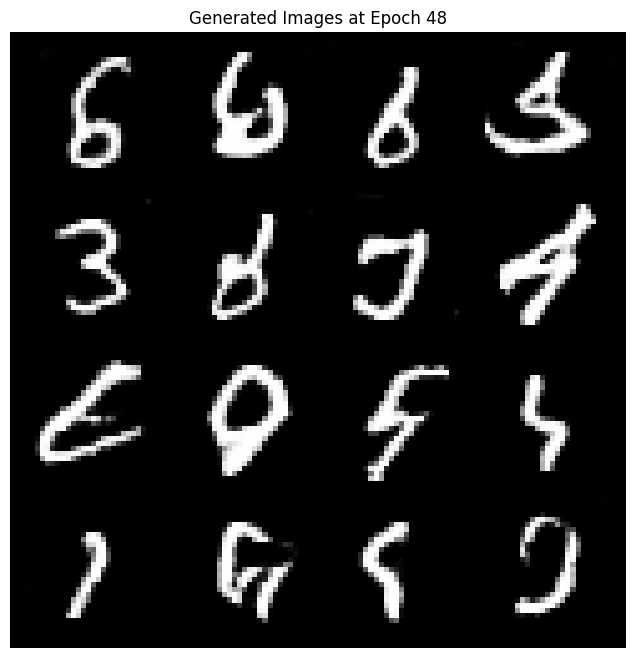

Epoch [49/50] Batch 100/938 Discriminator Loss: 0.2247 Generator Loss: 5.0905
Epoch [49/50] Batch 200/938 Discriminator Loss: 0.1355 Generator Loss: 2.9550
Epoch [49/50] Batch 300/938 Discriminator Loss: 0.1543 Generator Loss: 3.5245
Epoch [49/50] Batch 400/938 Discriminator Loss: 0.3121 Generator Loss: 2.1365
Epoch [49/50] Batch 500/938 Discriminator Loss: 0.1587 Generator Loss: 4.2942
Epoch [49/50] Batch 600/938 Discriminator Loss: 0.1827 Generator Loss: 2.8288
Epoch [49/50] Batch 700/938 Discriminator Loss: 0.1560 Generator Loss: 3.3692
Epoch [49/50] Batch 800/938 Discriminator Loss: 0.1086 Generator Loss: 3.8175
Epoch [49/50] Batch 900/938 Discriminator Loss: 0.1931 Generator Loss: 2.8984


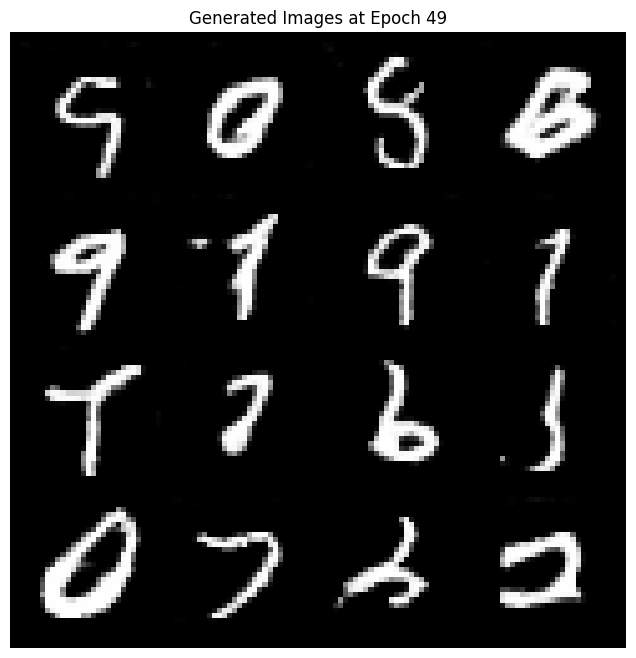

Epoch [50/50] Batch 100/938 Discriminator Loss: 0.1865 Generator Loss: 3.0034
Epoch [50/50] Batch 200/938 Discriminator Loss: 0.2161 Generator Loss: 2.0692
Epoch [50/50] Batch 300/938 Discriminator Loss: 0.2142 Generator Loss: 1.9557
Epoch [50/50] Batch 400/938 Discriminator Loss: 0.1757 Generator Loss: 4.3596
Epoch [50/50] Batch 500/938 Discriminator Loss: 0.1737 Generator Loss: 4.3168
Epoch [50/50] Batch 600/938 Discriminator Loss: 0.1354 Generator Loss: 3.4797
Epoch [50/50] Batch 700/938 Discriminator Loss: 0.2948 Generator Loss: 1.5884
Epoch [50/50] Batch 800/938 Discriminator Loss: 0.1613 Generator Loss: 3.8975
Epoch [50/50] Batch 900/938 Discriminator Loss: 0.1624 Generator Loss: 3.2154


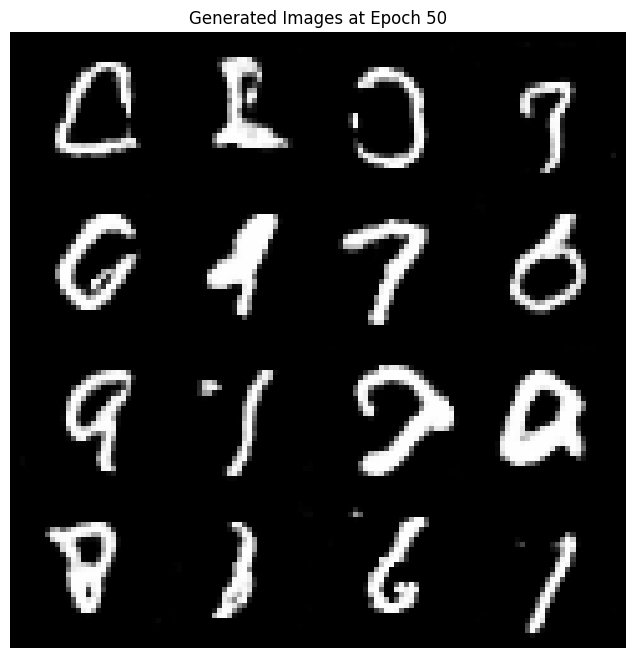

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 100
lr = 0.0002
batch_size = 64
num_epochs = 50
img_size = 28

# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (128, 7, 7)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.8),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        images = self.model(z)
        return images


# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128, momentum=0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, images):
        validity = self.model(images)
        return validity


# Loss function
adversarial_loss = nn.BCELoss()

# Initialize models
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('.', train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)

# Training Loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        # Prepare real and fake labels
        real_images = real_images.to(device)
        valid = torch.ones(real_images.size(0), 1, device=device)
        fake = torch.zeros(real_images.size(0), 1, device=device)

        # Train Discriminator
        optimizer_D.zero_grad()

        z = torch.randn(real_images.size(0), latent_dim, device=device)
        fake_images = generator(z)

        real_loss = adversarial_loss(discriminator(real_images), valid)
        fake_loss = adversarial_loss(discriminator(fake_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        gen_images = generator(z)
        g_loss = adversarial_loss(discriminator(gen_images), valid)

        g_loss.backward()
        optimizer_G.step()

        # Print progress
        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}] Batch {i+1}/{len(dataloader)} "
                f"Discriminator Loss: {d_loss.item():.4f} Generator Loss: {g_loss.item():.4f}"
            )

    # Save and display generated images at each epoch
    with torch.no_grad():
        z = torch.randn(16, latent_dim, device=device)
        generated = generator(z).detach().cpu()
        grid = torchvision.utils.make_grid(generated, nrow=4, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)), cmap="gray")
        plt.title(f"Generated Images at Epoch {epoch + 1}")
        plt.axis("off")
        plt.savefig(f"mnist_generated_epoch_{epoch + 1}.png")
        plt.show()

The generated images became clearer at first (e.g., Epoch 40) due to balanced learning between the generator and discriminator.

However, by later epochs (e.g., Epoch 50), the quality degraded because of issues like mode collapse, the discriminator overpowering the generator, or training instability.
Proper tuning of hyperparameters and balancing the adversarial game can help maintain quality.

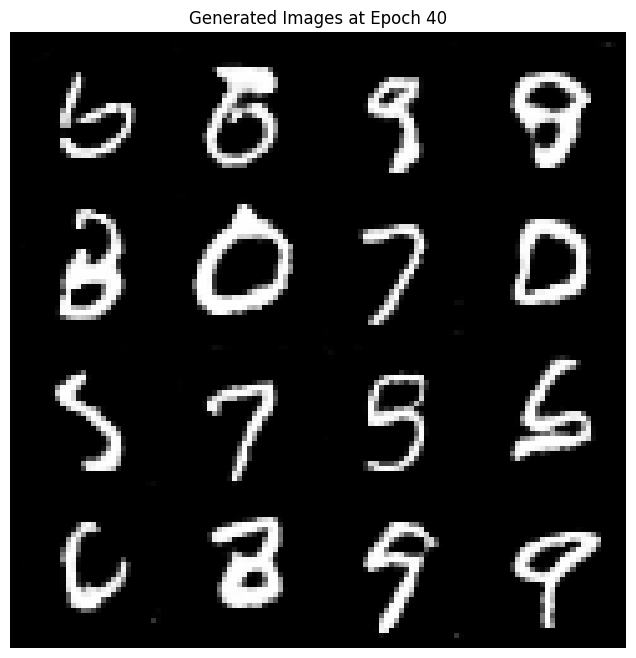

#Reference

* The above code was adapted from the following website. https://www.geeksforgeeks.org/generative-adversarial-network-gan/?ref=header_outind


